<br><br><br>
# Lab 1. Euler Beam (Solid Mechanics)

## 1.1. Problem Setup

- We will solve a Euler beam problem:


<br>
<center>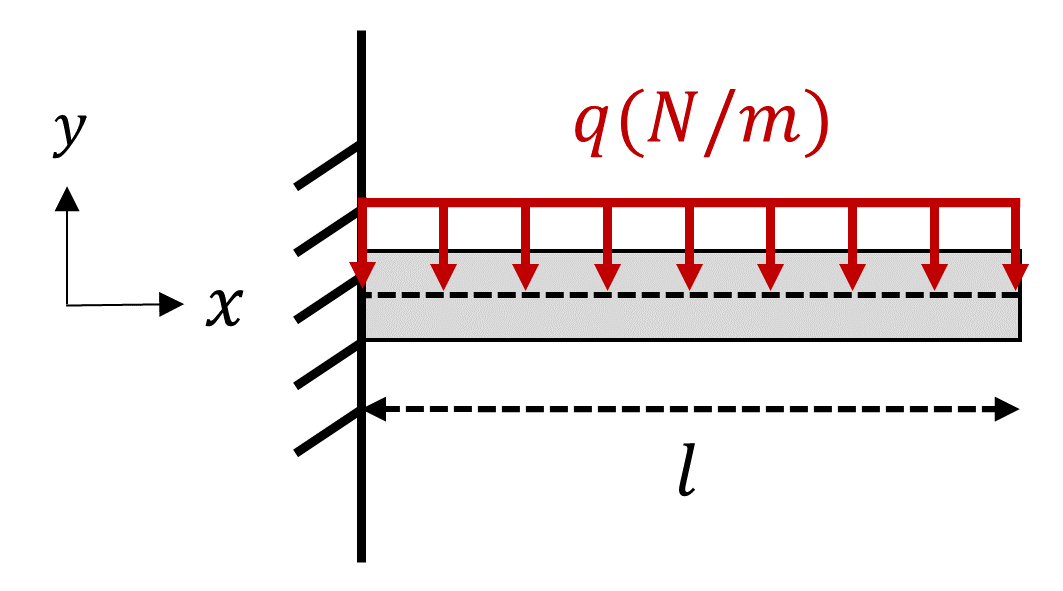</center>
<br>




- Problem properties

$$E = 1 \operatorname{pa}, \quad I = 1 \operatorname{kg\cdot m^2}, \quad q = 1 \operatorname{N/m}, \quad l = 1 \operatorname{m}$$
<br>

- Partial differential equations & boundary conditions

<br>
$${\partial^4 y \over \partial x^4} + q = 0,  \qquad \text{where} \quad x \in [0,1]$$
<br>

- One Dirichlet boundary condition on the left boundary:

<br>
$$y(0) = 0$$
<br>

- One Neumann boundary condition on the left boundary:

<br>
$$y'(0) = 0$$
<br>

- Two boundary conditions on the right boundary:

<br>
$$y''(1) = 0, \quad y'''(1) = 0$$
<br>

- The exact solution is

<br>
$$y(x) = -{1 \over 24}x^4 + {1 \over 6}x^3 - {1 \over 4}x^2$$
<br>

- Make a neural network and loss functions like below :


<br><br>
<center>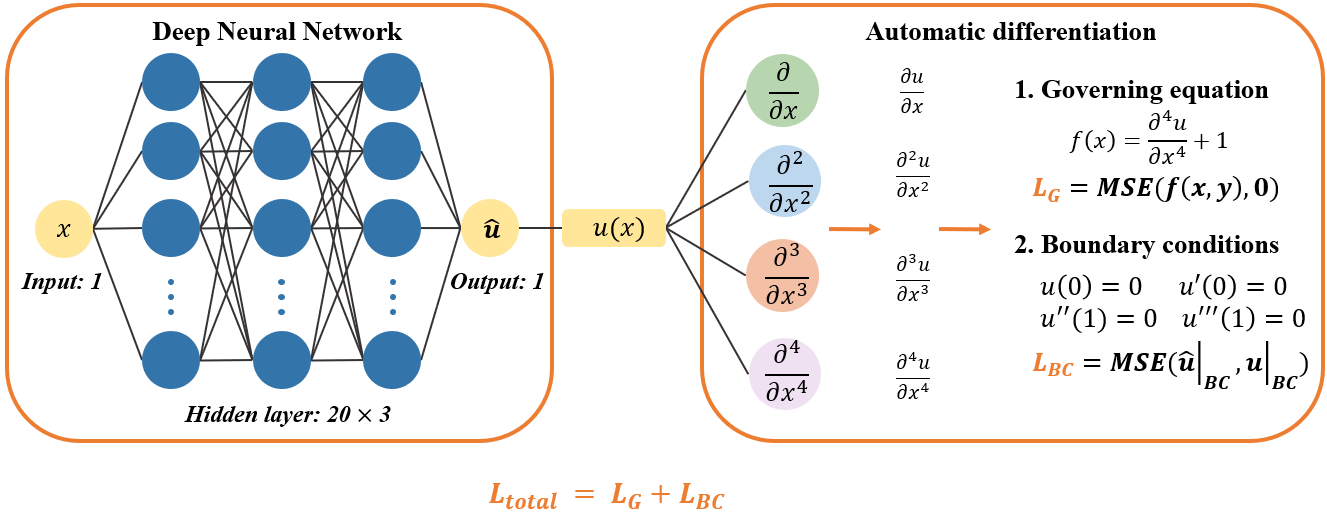</center>
<br>

## 1.2. Solve the Euler Beam problem

### 1.2.1. Import Library

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

### 1.2.2. Define Parameters

In [ ]:
E = 1
I = 1
q = 1
l = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### 1.2.3. Define Collocation Points

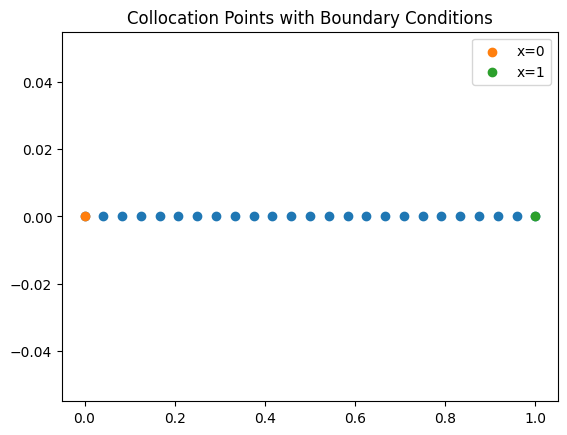

In [ ]:
x = np.linspace(0, l, 25)
y = np.zeros_like(x)
x0 = x[0]  # Boundary condition when x = 0
x1 = x[-1]  # Boundary condition when x = 1
plt.scatter(x, y)
plt.scatter(x0, 0, label='x=0')
plt.scatter(x1, 0, label='x=1')
plt.legend()
plt.title('Collocation Points with Boundary Conditions')
plt.show()

### 1.2.4. Define Network and Hyper-parameters

In [ ]:
import torch.nn as nn
from torch.nn import Linear, Tanh

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            Linear(1, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 1),
            Tanh(),
        )

    def forward(self, x):
        return self.net(x)

model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

### 1.2.5. Define PDE System

$${\partial^4 y \over \partial x^4} + q = 0,  \qquad \text{where} \quad x \in [0,1]$$
<br>

In [ ]:
def derivative(f, t):
    return torch.autograd.grad(f, t, grad_outputs = torch.ones_like(f), create_graph = True)[0]

def PDE(model, x):
    u = model(x)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    u_xxx = derivative(u_xx, x)
    u_xxxx = derivative(u_xxx, x)

    pde = u_xxxx + q
    return pde

### 1.2.6. Define Boundary Condition


- One Dirichlet boundary condition on the left boundary:

<br>
$$y(0) = 0$$
<br>

- One Neumann boundary condition on the left boundary:

<br>
$$y'(0) = 0$$
<br>

- Two boundary conditions on the right boundary:

<br>
$$y''(1) = 0, \quad y'''(1) = 0$$
<br>

In [ ]:
def BC_left(model, x_0):
    # x = 0
    u_0 = model(x_0)
    bc1 = u_0

    u_x_0 = derivative(u_0, x_0)
    bc2 = u_x_0
    return bc1, bc2

def BC_right(model, x_f):
    # x = 1
    u_f = model(x_f)
    u_x_f = derivative(u_f, x_f)
    u_xx_f = derivative(u_x_f, x_f)
    bc3 = u_xx_f

    u_xxx_f = derivative(u_xx_f, x_f)
    bc4 = u_xxx_f
    return bc3, bc4

### 1.2.7. Define Exact Solution

In [ ]:
def exact_solution(x):
    return -(x ** 4) / 24 + x ** 3 / 6 - x ** 2 / 4

### 1.2.8. Train & Prediction

In [ ]:
def require_grad(x, device=device):
    return torch.tensor(x, device=device, dtype=torch.float32, requires_grad=True)

epochs = 3001

x = require_grad(x.reshape(-1, 1))
x0 = require_grad(x0.reshape(-1, 1))
x1 = require_grad(x1.reshape(-1, 1))

for epoch in range(epochs):
    pde_term = PDE(model, x)
    bc1, bc2 = BC_left(model, x0)
    bc3, bc4 = BC_right(model, x1)

    loss_pde = loss_fn(pde_term, torch.zeros_like(pde_term).to(device))
    loss_bc1 = loss_fn(bc1, torch.zeros_like(bc1).to(device))
    loss_bc2 = loss_fn(bc2, torch.zeros_like(bc2).to(device))
    loss_bc3 = loss_fn(bc3, torch.zeros_like(bc3).to(device))
    loss_bc4 = loss_fn(bc4, torch.zeros_like(bc4).to(device))
    loss_bc = loss_bc1 + loss_bc2 + loss_bc3 + loss_bc4

    loss = loss_pde + loss_bc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

print('Training Finsh')

Epoch 0, Loss: 1.060953140258789
Epoch 1000, Loss: 6.542677147081122e-05
Epoch 2000, Loss: 0.0001579928066348657
Epoch 3000, Loss: 1.8515955162001774e-05
Training Finsh


### 1.2.6. Result

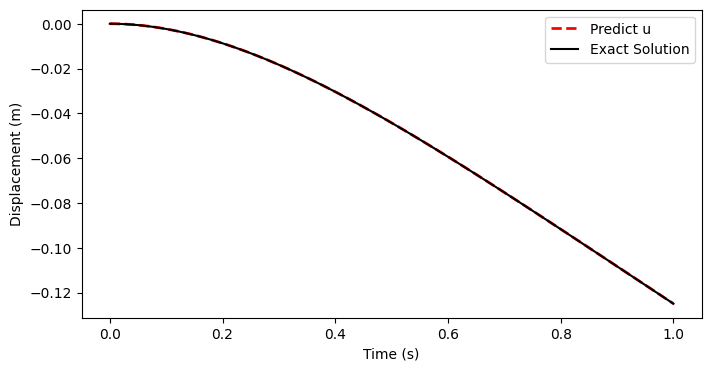

In [ ]:
x_ = np.linspace(0, l, 100)
x_ = torch.tensor(x_.reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    model.cpu()
    model.eval()
    u_ = model(x_)

plt.figure(figsize = (8, 4))
plt.plot(x_, u_.detach().numpy(), c =  'r', label = 'Predict u', linestyle = 'dashed', linewidth = 2)
plt.plot(x_, exact_solution(x_), c =  'k', label = 'Exact Solution')
plt.legend(fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (s)', fontsize = 10)
plt.ylabel('Displacement (m)', fontsize = 10)
plt.show()



---



<br><br><br>
# Lab 2. Pendulum (Rigid Body ODE)

## 2.1. Problem Setup

- We will solve a pendulum problem:

<br>

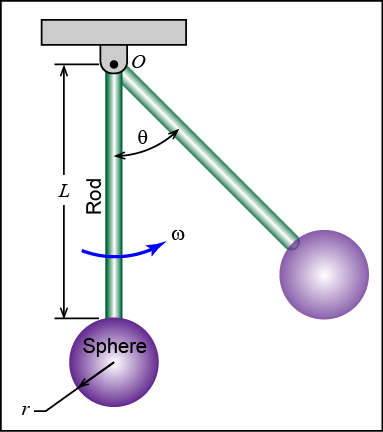

<br>



- Problem properties

$$
g = 9.81\;\mathrm{m/s^2}, \quad
L = 0.025\;\mathrm{m}, \quad
\theta_0 = \frac{\pi}{4}\;\mathrm{rad}, \quad
\dot{\theta}_0 = 0
$$
<br>

- Ordinary differential equation & initial conditions

<br>
$$
\frac{d^2\theta}{dt^2} + \frac{g}{L}\sin(\theta) = 0,
\qquad \text{where} \quad t \in [0,\,1]
$$
<br>

- Initial condition for angular displacement:

<br>
$$
\theta(0) = \theta_0
$$
<br>

- Initial condition for angular velocity:

<br>
$$
\frac{d\theta}{dt}(0) = \dot{\theta}_0
$$
<br>

- Reference (exact) solution

<br>
The nonlinear pendulum does not admit a simple closed-form solution.
Therefore, the reference solution is defined as the numerical solution
of the governing ODE obtained using a high-accuracy ODE solver (e.g. `odeint`).

For comparison, the small-angle approximation (\(|\theta|\ll 1\)) yields

$$
\frac{d^2\theta}{dt^2} + \frac{g}{L}\theta = 0
$$

with the analytical solution

$$
\theta_{\text{lin}}(t)
=
\theta_0 \cos\!\left(\sqrt{\frac{g}{L}}\,t\right).
$$
<br>

- Make a neural network and loss functions like below :

<br><br>

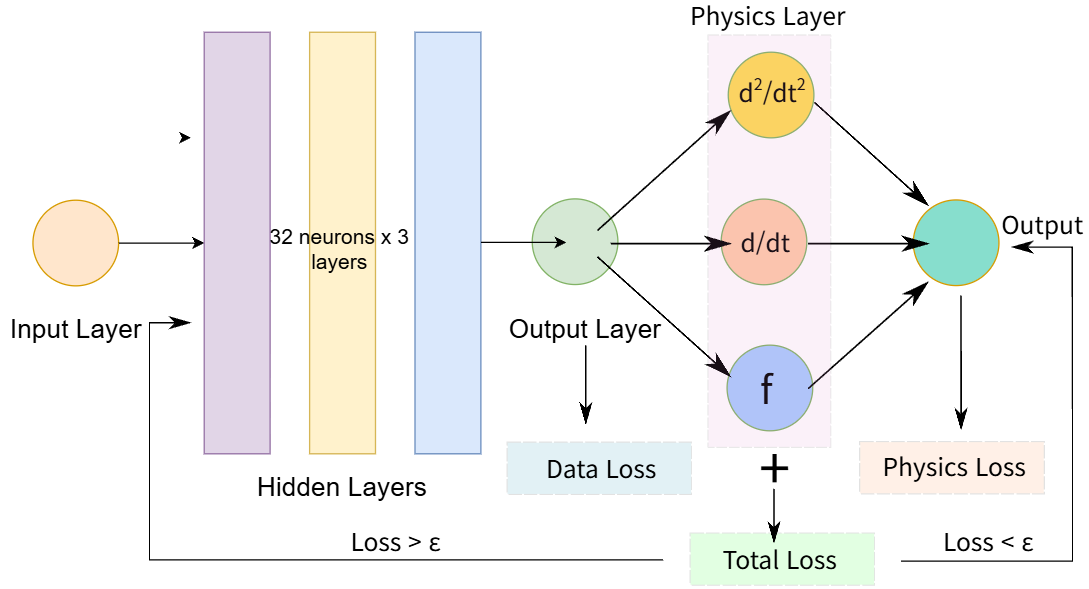

<br>


## 2.2. Solve the Pendulum problem

### 2.2.1. Import Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### 2.2.2. Define Parameters

In [2]:
# Parameters
L = 0.025  # length of pendulum (m)
g = 9.81   # gravity (m/s^2)

w = np.sqrt(g / L)
k = w**2              # k = g/L
end_time = 1.0

# Initial condition
theta0 = np.pi / 4
omega0 = 0.0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### 2.2.3. Define Collocation Points (time domain) & Training data

In [3]:
# Create a one-dimensional time array
t = np.linspace(0, end_time, 500)

# torch tensor (full domain)
x = torch.tensor(t, dtype=torch.float32, device=device).view(-1, 1)

# "physics" collocation points (for physics loss)
x_physics = torch.linspace(0, end_time, 30, device=device).view(-1, 1)
x_physics.requires_grad_(True)

# Training data points (sparse samples, like experimental data)
# (same sampling as the blog: 0~200 range, step 20)
x_data = x[0:200:20].clone().detach()

###2.2.4. Define Exact/Reference Solution (odeint) + Small Angle Approx.

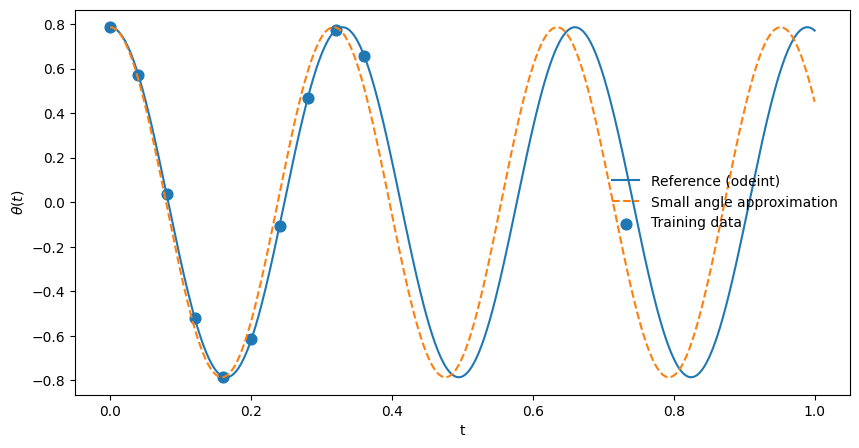

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


In [4]:
# ODE function for nonlinear pendulum (reference solution)
def simple_pendulum_eqn(state, t):
    theta, theta_dot = state
    theta_ddot = -k * np.sin(theta)
    return [theta_dot, theta_ddot]

initial_state = [theta0, omega0]

# Numerical solution (reference)
states = odeint(simple_pendulum_eqn, initial_state, t)
y = torch.tensor(states[:, 0], dtype=torch.float32, device=device).view(-1, 1)

# Training labels (sparse)
y_data = y[0:200:20].clone().detach()

# Small-angle approximation analytical solution
def small_angle_solution(w, x_torch):
    return theta0 * torch.cos(torch.tensor(w, device=x_torch.device) * x_torch)

# Plot reference vs small-angle + training data
plt.figure(figsize=(10, 5))
plt.plot(x.detach().cpu().numpy(), y.detach().cpu().numpy(), label='Reference (odeint)')
plt.plot(x.detach().cpu().numpy(),
         small_angle_solution(w, x).detach().cpu().numpy(),
         '--', label='Small angle approximation')
plt.scatter(x_data.detach().cpu().numpy(), y_data.detach().cpu().numpy(),
            s=60, label='Training data')
plt.xlabel('t')
plt.ylabel(r'$\theta(t)$')
plt.legend(frameon=False)
plt.show()

print(x.shape, y.shape)
print(x_data.shape, y_data.shape)

### 2.2.4. Define Network and Hyper-parameters

In [5]:
import torch.nn as nn
from torch.nn import Linear, Tanh

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            Linear(1, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 1),
            # (선택) 출력 범위를 제한하고 싶으면 Tanh()를 마지막에 붙일 수 있음
            # Tanh(),
        )

    def forward(self, t):
        return self.net(t)

model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

### 2.2.5. Define ODE System

$$
\frac{d^2\theta}{dt^2} + \frac{g}{L}\sin(\theta) = 0,
\qquad \text{where} \quad t \in [0,\,1]
$$
<br>

In [6]:
def derivative(f, t):
    return torch.autograd.grad(f, t, grad_outputs=torch.ones_like(f), create_graph=True)[0]

def ODE(model, t):
    theta = model(t)
    theta_t = derivative(theta, t)
    theta_tt = derivative(theta_t, t)

    ode = theta_tt + (g / L) * torch.sin(theta)
    return ode

### 1.2.6. Define Boundary Condition

- Initial condition for angular displacement:

<br>
$$
\theta(0) = \theta_0
$$
<br>

- Initial condition for angular velocity:

<br>
$$
\frac{d\theta}{dt}(0) = \dot{\theta}_0
$$
<br>

In [7]:
def IC(model, t0):
    # t = 0
    theta0_pred = model(t0)
    ic1 = theta0_pred - theta0  # theta(0) = theta0

    theta0_t = derivative(theta0_pred, t0)
    ic2 = theta0_t - omega0     # theta'(0) = omega0
    return ic1, ic2

### 1.2.7. Define Exact Solution

In [8]:
def exact_solution_nonlinear(t_np, theta0, omega0):
    # reference solution via numerical integration (odeint)
    from scipy.integrate import odeint
    import numpy as np

    def simple_pendulum_eqn(state, t):
        theta, theta_dot = state
        theta_ddot = -(g / L) * np.sin(theta)
        return [theta_dot, theta_ddot]

    states = odeint(simple_pendulum_eqn, [theta0, omega0], t_np)
    return states[:, 0:1]  # theta(t)

def exact_solution_small_angle(t_tensor):
    # theta_lin(t) = theta0 * cos(sqrt(g/L) * t)
    w = np.sqrt(g / L)
    return theta0 * torch.cos(torch.tensor(w, device=t_tensor.device) * t_tensor)

### 1.2.8. Train & Prediction

In [9]:
def require_grad(x, device=device):
    return torch.tensor(x, device=device, dtype=torch.float32, requires_grad=True)

# time domain
t_np = np.linspace(0, end_time, 500).reshape(-1, 1)

# collocation points (physics)
t = require_grad(t_np)

# initial condition point t0 = 0
t0 = require_grad(np.array([[0.0]]))

# (선택) sparse training data (data loss를 추가하고 싶다면)
# blog와 동일: 0~200 index에서 20 step 간격
t_data = require_grad(t_np[0:200:20])
theta_ref_np = exact_solution_nonlinear(t_np.flatten(), theta0, omega0)  # (500,1)
theta_ref = torch.tensor(theta_ref_np, dtype=torch.float32, device=device)

theta_data = theta_ref[0:200:20].detach()  # data는 grad 불필요

epochs = 20001
lambda_phys = 1e-4  # physics loss weight (블로그 스타일)
lambda_ic = 1.0
lambda_data = 1.0

for epoch in range(epochs):
    ode_term = ODE(model, t)
    ic1, ic2 = IC(model, t0)

    # physics loss
    loss_ode = loss_fn(ode_term, torch.zeros_like(ode_term).to(device))

    # IC loss (Euler beam BC처럼 2개 항)
    loss_ic1 = loss_fn(ic1, torch.zeros_like(ic1).to(device))
    loss_ic2 = loss_fn(ic2, torch.zeros_like(ic2).to(device))
    loss_ic = loss_ic1 + loss_ic2

    # data loss (선택: PINN+data로 보고 싶으면 포함)
    theta_pred_data = model(t_data)
    loss_data = loss_fn(theta_pred_data, theta_data)

    # total loss (Euler beam처럼 합산)
    loss = lambda_data * loss_data + lambda_phys * loss_ode + lambda_ic * loss_ic

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 2000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6e} | Data: {loss_data.item():.3e} | ODE: {loss_ode.item():.3e} | IC: {loss_ic.item():.3e}')

print('Training Finish')

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 9.580604e-01 | Data: 3.365e-01 | ODE: 5.585e+02 | IC: 5.657e-01
Epoch 2000, Loss: 4.074831e-01 | Data: 2.298e-01 | ODE: 1.236e+03 | IC: 5.408e-02
Epoch 4000, Loss: 1.628289e-01 | Data: 5.468e-02 | ODE: 1.037e+03 | IC: 4.419e-03
Epoch 6000, Loss: 9.805369e-02 | Data: 1.909e-02 | ODE: 7.773e+02 | IC: 1.237e-03
Epoch 8000, Loss: 8.757836e-02 | Data: 1.567e-02 | ODE: 7.093e+02 | IC: 9.808e-04
Epoch 10000, Loss: 7.041640e-02 | Data: 1.084e-02 | ODE: 5.885e+02 | IC: 7.292e-04
Epoch 12000, Loss: 6.361412e-02 | Data: 7.796e-03 | ODE: 5.534e+02 | IC: 4.749e-04
Epoch 14000, Loss: 6.149701e-02 | Data: 6.920e-03 | ODE: 5.412e+02 | IC: 4.550e-04
Epoch 16000, Loss: 5.978082e-02 | Data: 6.428e-03 | ODE: 5.296e+02 | IC: 3.885e-04
Epoch 18000, Loss: 5.833982e-02 | Data: 6.073e-03 | ODE: 5.190e+02 | IC: 3.676e-04
Epoch 20000, Loss: 5.720976e-02 | Data: 5.772e-03 | ODE: 5.108e+02 | IC: 3.582e-04
Training Finish


### 1.2.6. Result

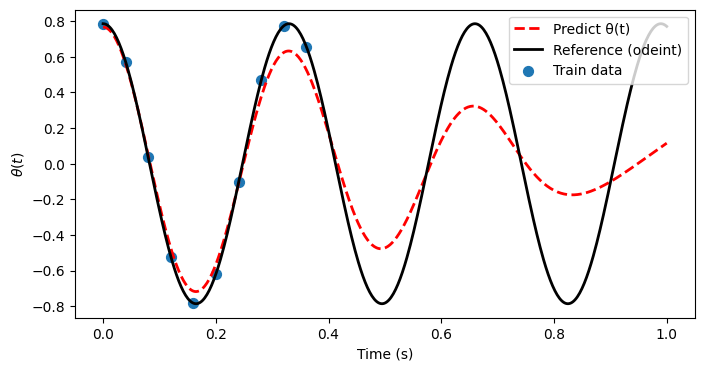

In [10]:
t_plot_np = np.linspace(0, end_time, 500).reshape(-1, 1)
t_plot = torch.tensor(t_plot_np, dtype=torch.float32, device=device)

with torch.no_grad():
    model.eval()
    theta_pred = model(t_plot).detach().cpu().numpy()

theta_ref_np = exact_solution_nonlinear(t_plot_np.flatten(), theta0, omega0)

plt.figure(figsize=(8, 4))
plt.plot(t_plot_np, theta_pred, 'r--', linewidth=2, label='Predict θ(t)')
plt.plot(t_plot_np, theta_ref_np, 'k', linewidth=2, label='Reference (odeint)')
plt.scatter(t_np[0:200:20], theta_ref_np[0:200:20], s=50, label='Train data')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel(r'$\theta(t)$')
plt.show()



---



<br><br><br>
# Lab 2. Thin Plate (Solid Mechanics)

## 2.1. Problem Setup

- We will solve thin plate equations to find displacement and stress distribution of thin plate


- Based on _Kirchhoff-Love_ plate theory, three hypotheses were used
    - straight lines normal to the mid-surface remain straight after deformation
    - straight lines normal to the mid-surface remain normal to the mid-surface after deformation
    - the thickness of the plate does not change during a deformation


- A non-uniform stretching force is applied to square elastic plate


- Only one quarter of the plate is considered since the geometry and in-plane forces are symmetric (yellow domain)

<br>
<center>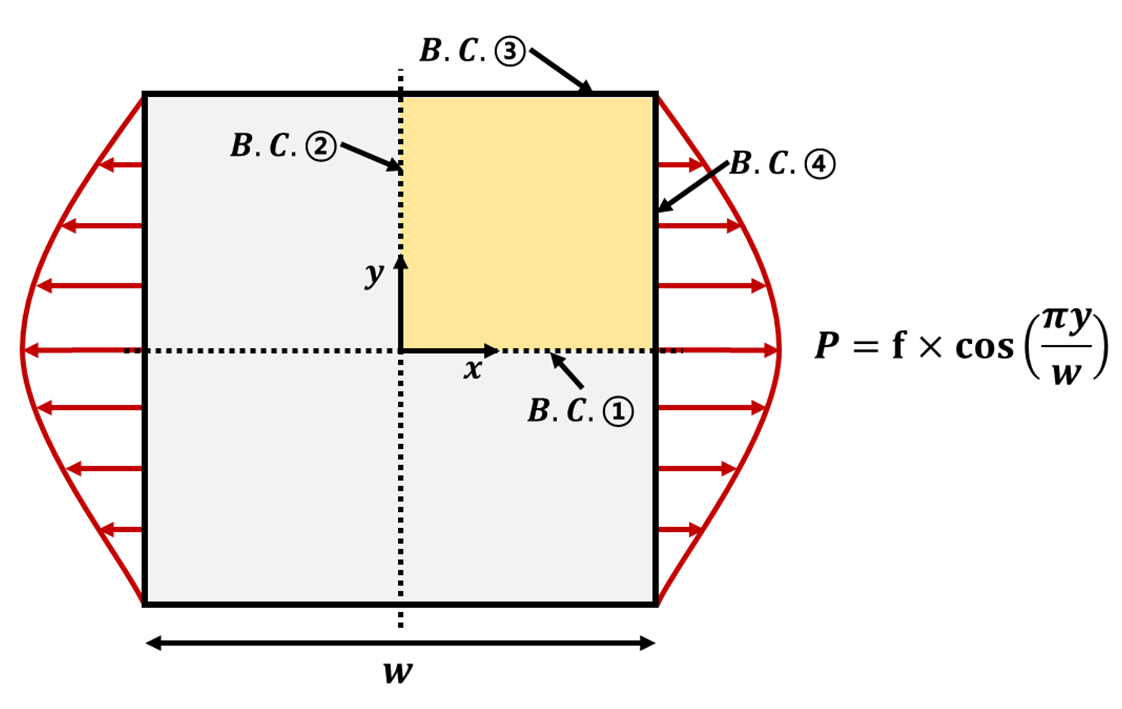</center>



<br><br>

- Problem properties

<br>
$$
E = 50 \operatorname{Mpa}, \quad \nu = 0.3, \quad \omega = 20 \operatorname{mm}, \quad h = 1 \operatorname{mm}, \quad f = 1 \operatorname{Mpa}
$$
<br>

- Governing equations (Föppl–von Kármán equations) for the isotropic elastic plate:


<br>
$$
\begin{align*}
&{E \over 1 - \nu^2}\left({\partial^2 u \over \partial x^2} + {1 - \nu \over 2}{\partial^2 u \over \partial y^2} + {1 + \nu \over 2}{\partial^2 v \over \partial x \partial y} \right) = 0\\\\
&{E \over 1 - \nu^2}\left({\partial^2 v \over \partial y^2} + {1 - \nu \over 2}{\partial^2 v \over \partial x^2} + {1 + \nu \over 2}{\partial^2 x \over \partial x \partial y} \right) = 0
\end{align*}
$$
<br>


- Two Dirichlet boundary conditions at $x = 0,\, y = 0\; (B.C.①, B.C.②)$:

<br>
$$
v(x,y) = 0 \qquad \text{at} \quad y = 0\\\\
u(x,y) = 0 \qquad \text{at} \quad x = 0
$$
<br>

- Two free boundary conditions at $y = \omega / 2\; (B.C.③)$:

<br>
$$
\sigma_{yy} = 0,\quad \sigma_{yx} = 0
$$
<br>

- Free boundary condition and in-plane force boundary condition at $x = \omega / 2\; (B.C.④)$:

<br>
$$
\sigma_{xx} = P \centerdot h,\quad \sigma_{xy} = 0
$$
<br>

- Make a neural network and loss funcitons like below:

<br><br>
<center>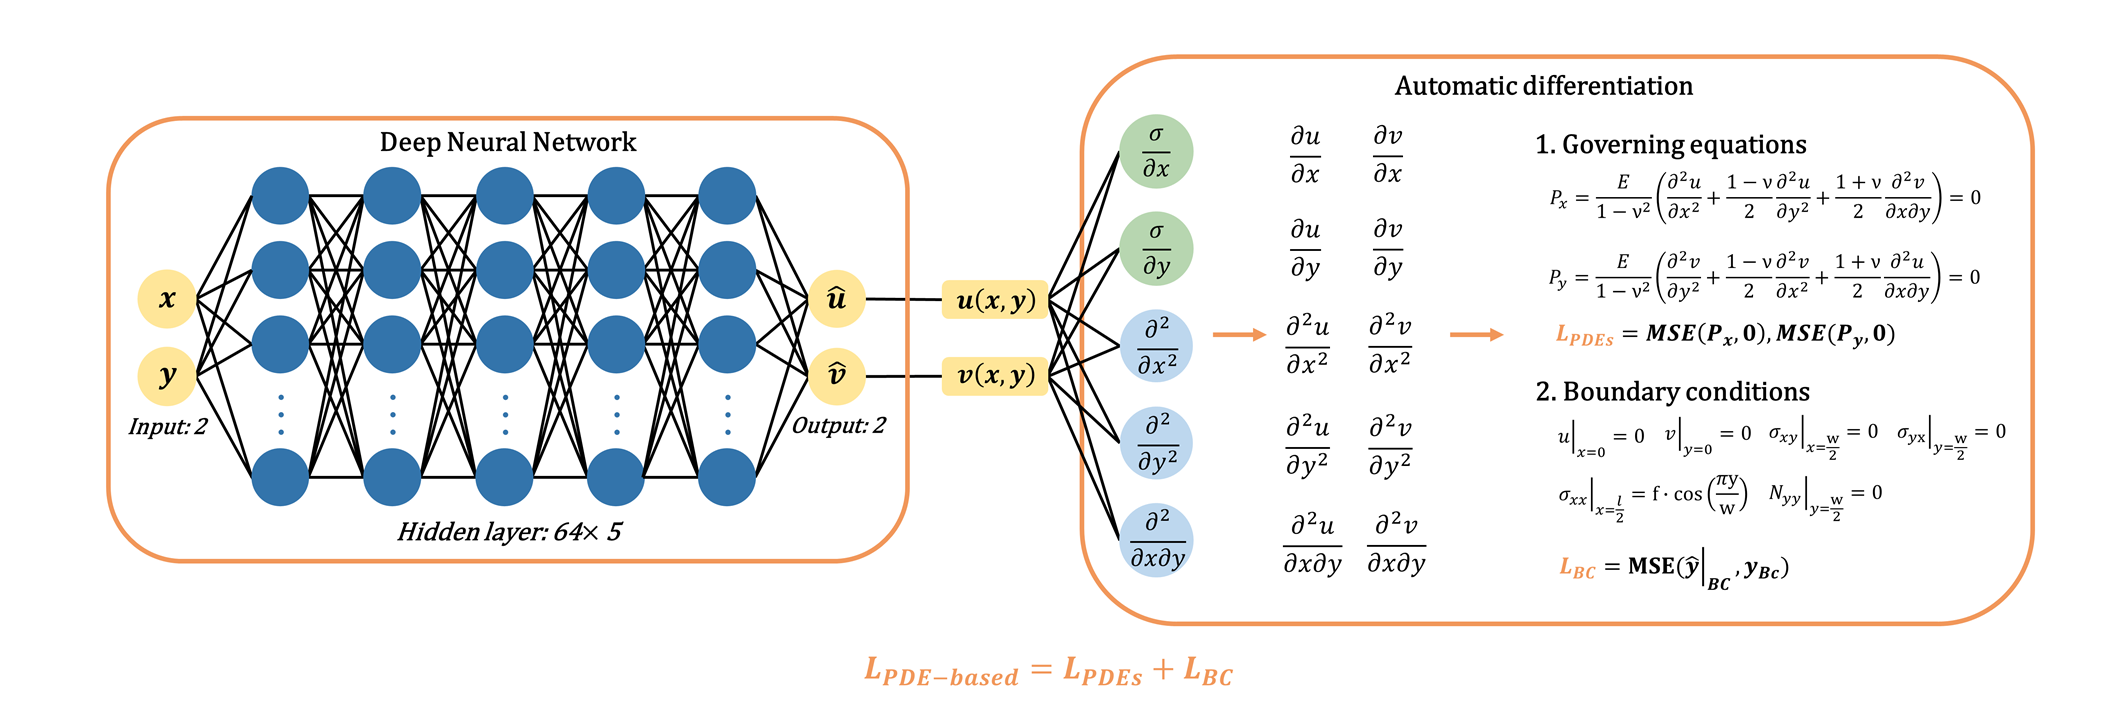</center>
<br><br>

## 2.1.1. Numerical Solution
- Numerical solution of this problem is illustrated in below figures
 - $x, y$ direction displacement and stress $u$, $v$, $\sigma_{xx}$, $\sigma_{yy}$, respectively
    
    
- Solve this problem using PINN and then compare with a numerical solution



<br>
<center>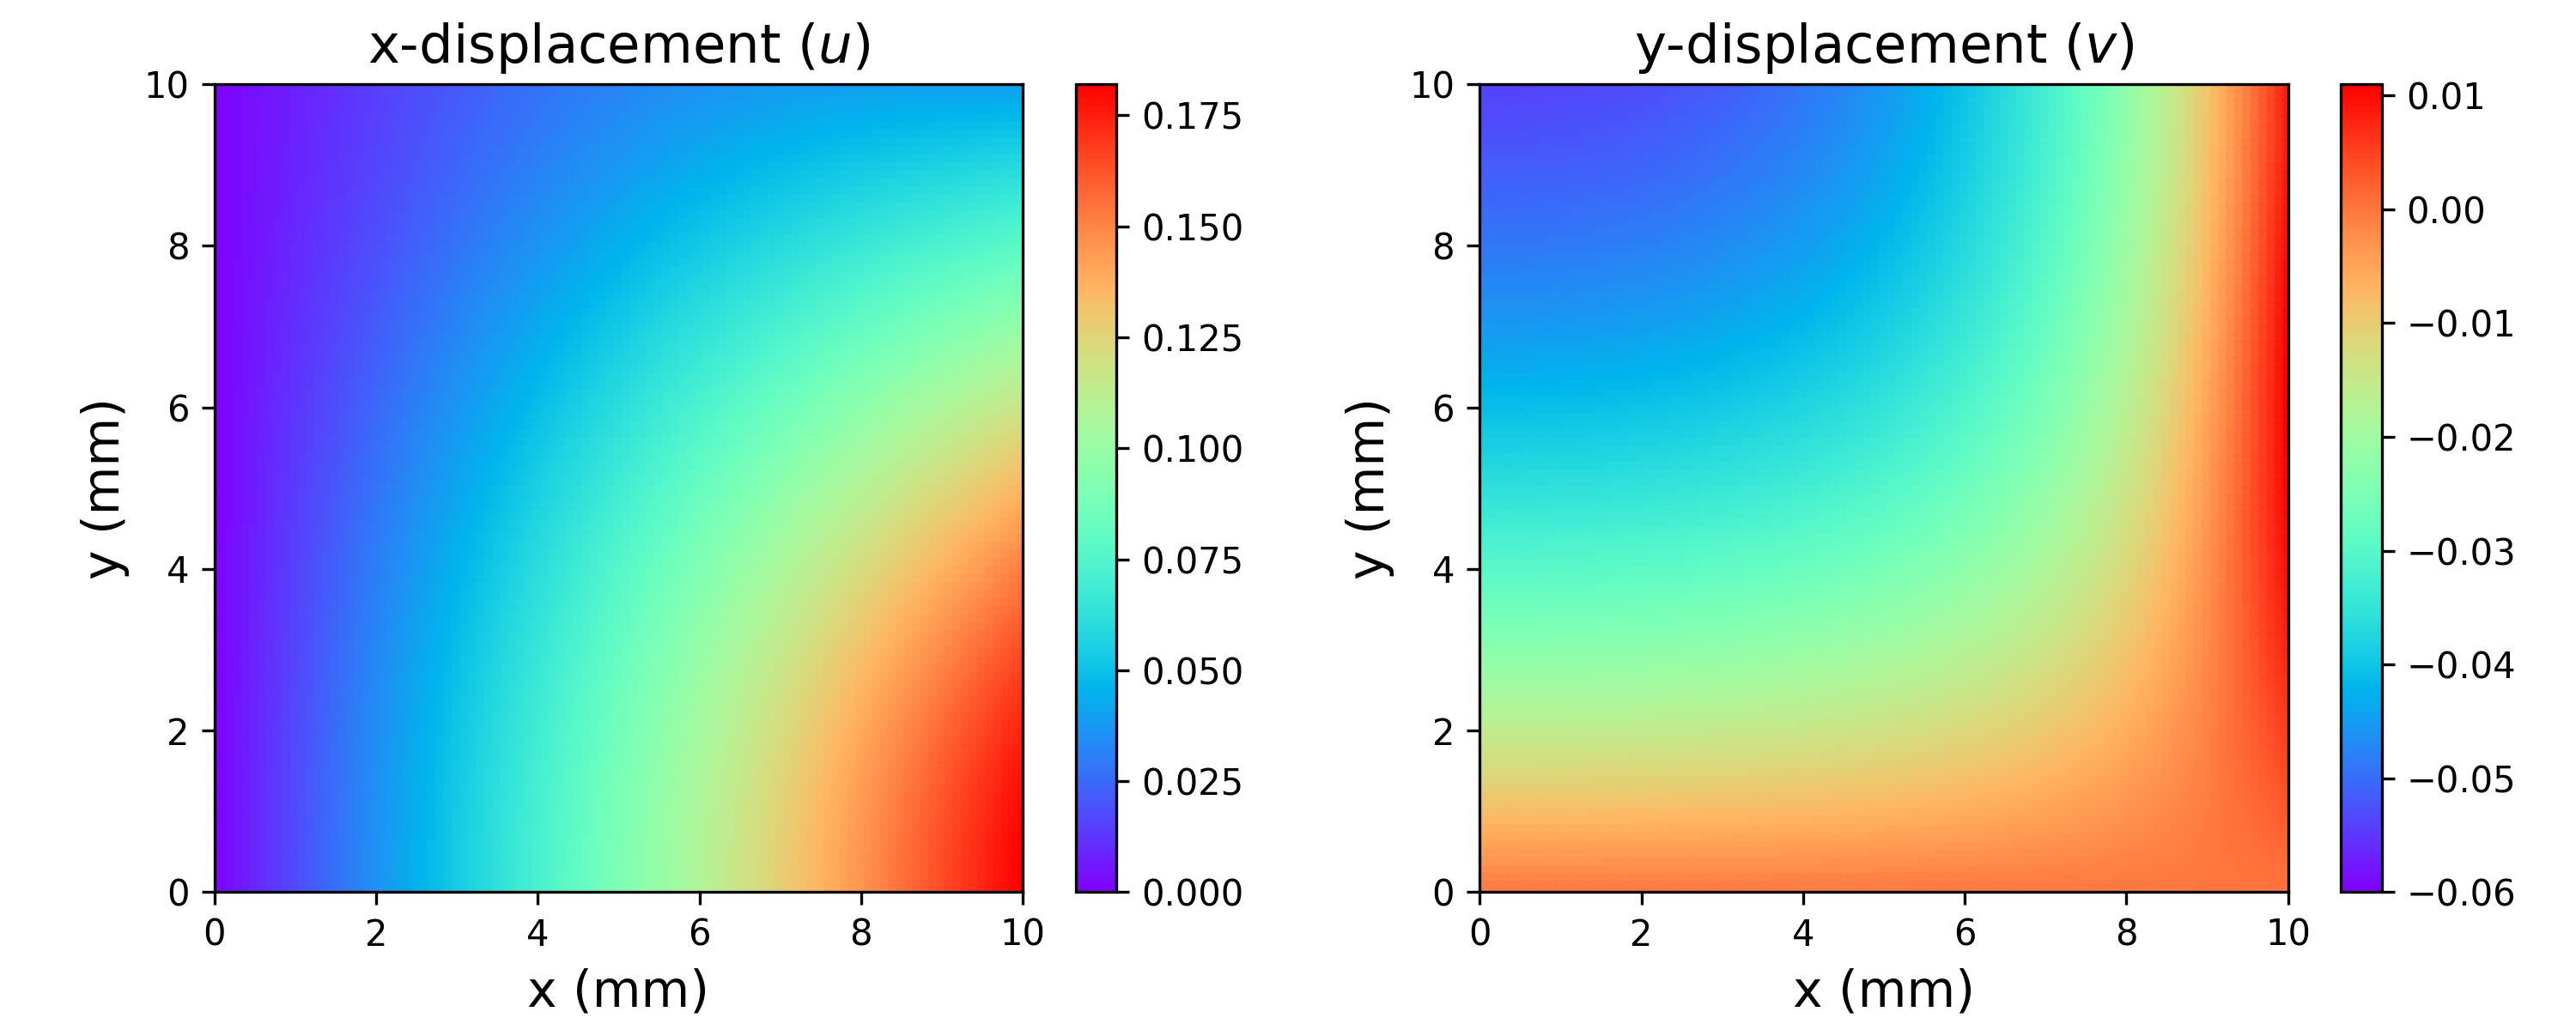</center>
<center>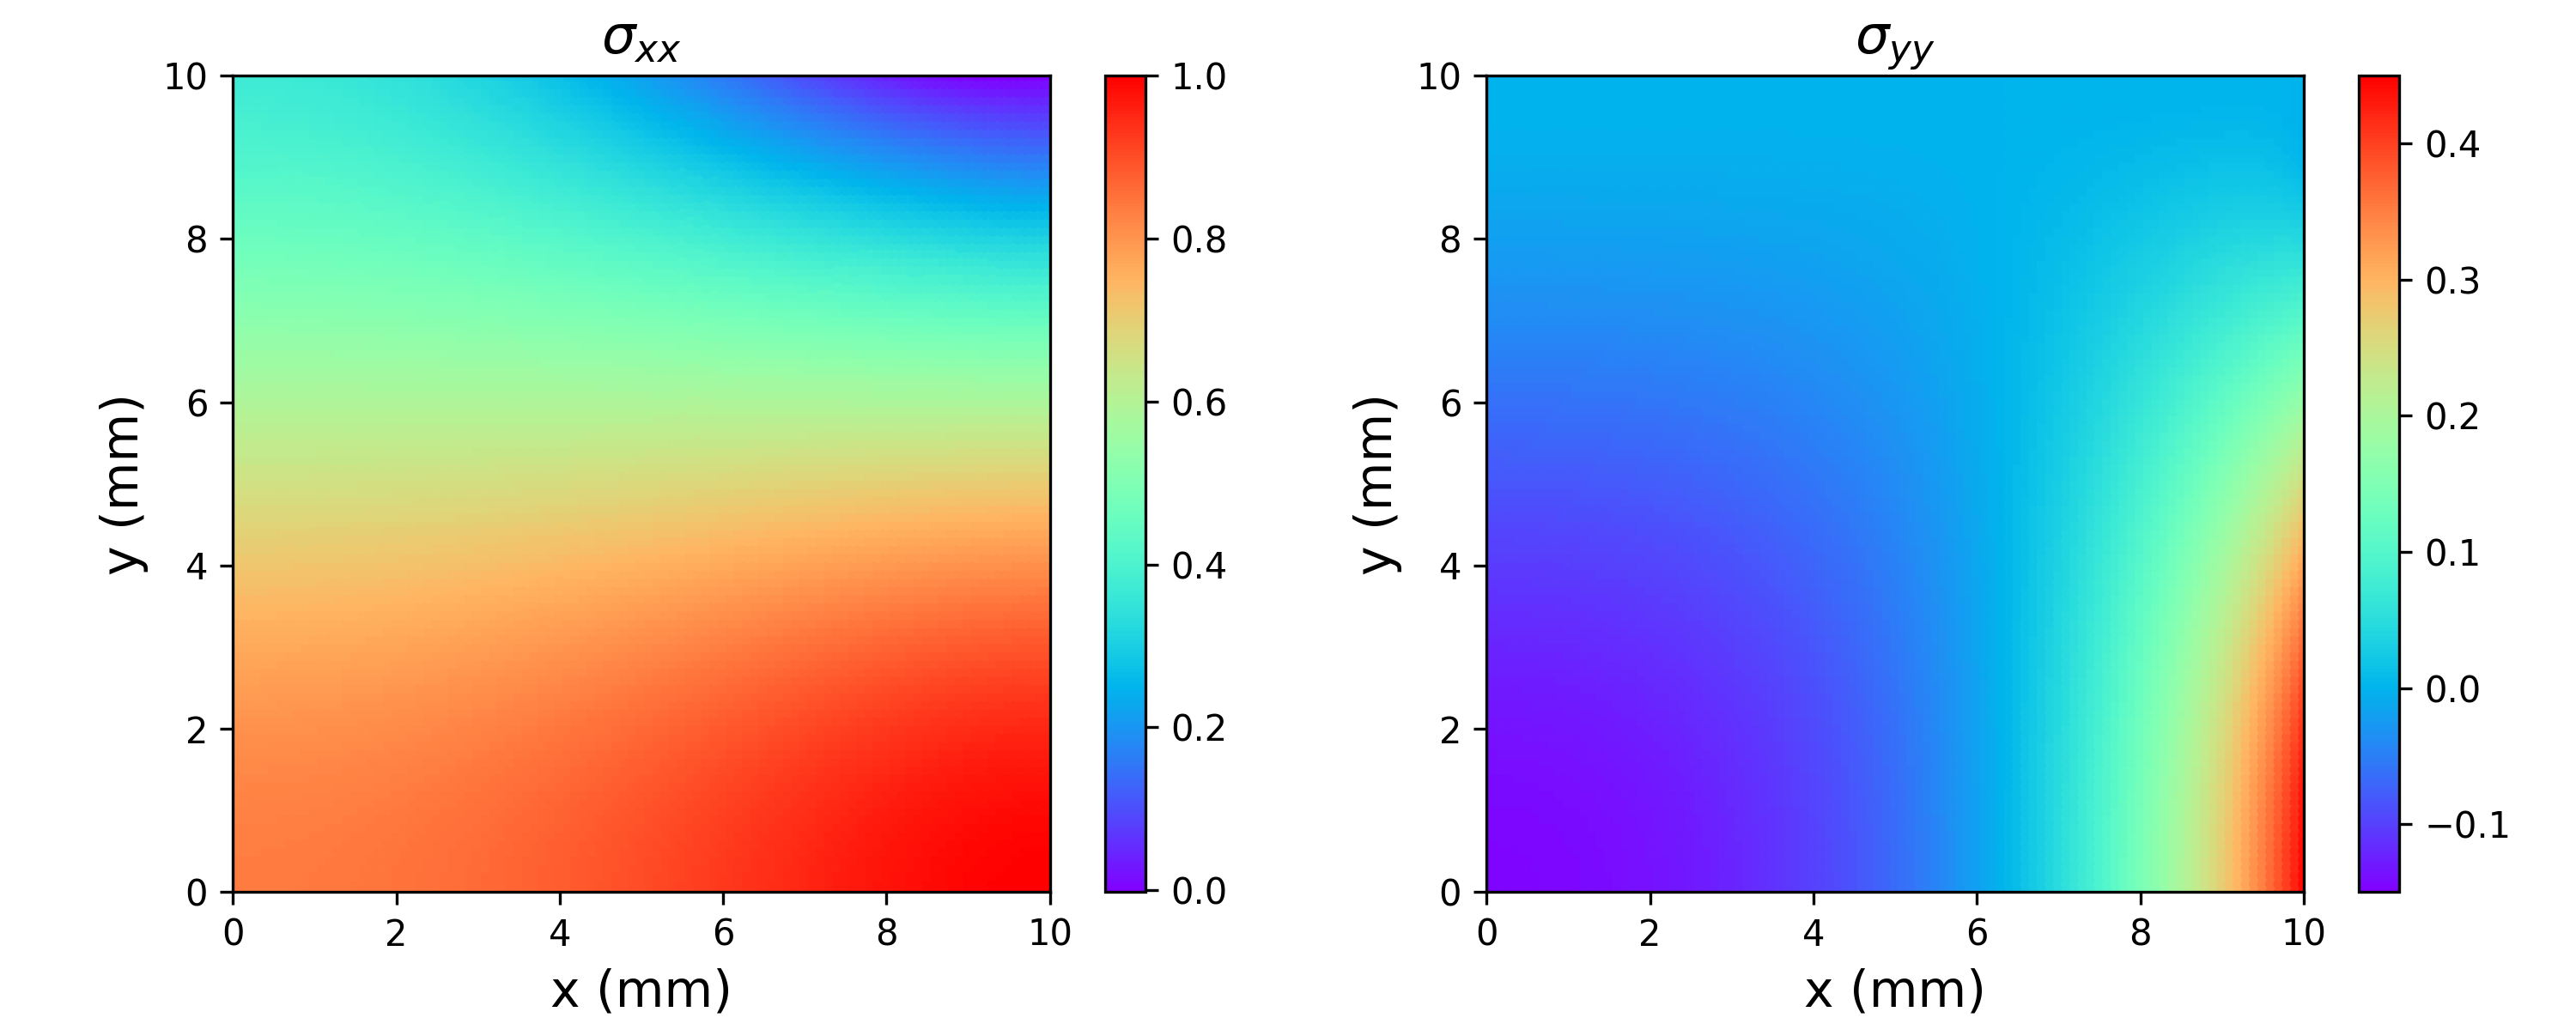</center>
<br>

## 2.2. PINN as PDE Solver

### 2.2.1. Import Library & Define Properties

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# properties
E = 50.0
nu = 0.3
w = 10.0
f = 1.0
h = 1.0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2.2. Define Collocation Points

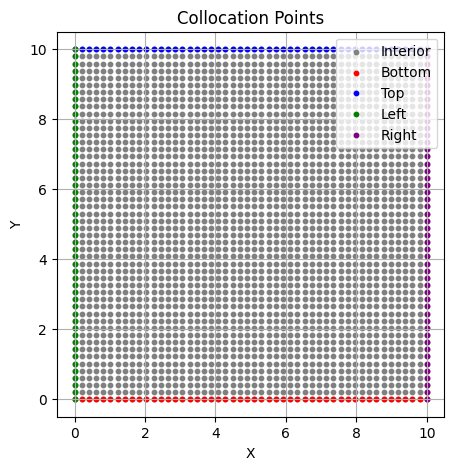

In [ ]:
Nx = 50                                                   # Number of samples
Ny = 50                                                   # Number of samples
x = torch.linspace(0, w, Nx)                              # Input data for x (Nx x 1)
y = torch.linspace(0, w, Ny)                             # Input data for y (Ny x 1)

xy = torch.meshgrid(x, y)
XY_domain = torch.cat([xy[0].reshape(-1, 1), xy[1].reshape(-1, 1)], dim=1)

XY_left = XY_domain[XY_domain[:, 0] == 0]
XY_right = XY_domain[XY_domain[:, 0] == w]
XY_top = XY_domain[XY_domain[:, 1] == w]
XY_bottom = XY_domain[XY_domain[:, 1] == 0]

plt.figure(figsize=(5, 5))
plt.scatter(XY_domain[:, 0], XY_domain[:, 1], s=10, color='gray', label='Interior')
plt.scatter(XY_bottom[:, 0], XY_bottom[:, 1], s=10, color='red', label='Bottom')
plt.scatter(XY_top[:, 0], XY_top[:, 1], s=10, color='blue', label='Top')
plt.scatter(XY_left[:, 0], XY_left[:, 1], s=10, color='green', label='Left')
plt.scatter(XY_right[:, 0], XY_right[:, 1], s=10, color='purple', label='Right')

plt.legend()
plt.title('Collocation Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

### 2.2.3. Define Network and Hyper-parameters

In [ ]:
import torch.nn as nn
from torch.nn import Linear, Tanh

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
        Linear(2, 64),
        Tanh(),
        Linear(64, 64),
        Tanh(),
        Linear(64, 64),
        Tanh(),
        Linear(64, 64),
        Tanh(),
        Linear(64, 64),
        Tanh(),
        Linear(64, 64),
        Tanh(),
        Linear(64, 2)
        )

        self._initialize_weights()

    '''
    Xavier initializer (Glorot initialization):
    Initializes the weights to keep the variance consistent across layers,
    preventing issues like vanishing or exploding gradients. Weights are
    drawn from a distribution with variance 2/(fan_in + fan_out).
    Biases are set to zero.
    '''
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.float()
        output = self.net(x)
        u, v = output[:, 0:1], output[:, 1:2]
        return u, v

model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

### 2.2.4. Define PDE with Boundary Conditions

- Governing equations (Föppl–von Kármán equations) for the isotropic elastic plate:


<br>
$$
\begin{align*}
&{E \over 1 - \nu^2}\left({\partial^2 u \over \partial x^2} + {1 - \nu \over 2}{\partial^2 u \over \partial y^2} + {1 + \nu \over 2}{\partial^2 v \over \partial x \partial y} \right) = 0\\\\
&{E \over 1 - \nu^2}\left({\partial^2 v \over \partial y^2} + {1 - \nu \over 2}{\partial^2 v \over \partial x^2} + {1 + \nu \over 2}{\partial^2 u \over \partial x \partial y} \right) = 0
\end{align*}
$$
<br>

In [ ]:
def derivative(y, t) :
    df = torch.autograd.grad(y, t, grad_outputs = torch.ones_like(y).to(device), create_graph = True)[0]
    df_x = df[:, 0:1]
    df_y = df[:, 1:2]
    return df_x, df_y

def PDE(model, XY_domain):
    u, v = model(XY_domain)

    du_x, du_y = derivative(u, XY_domain)
    dv_x, dv_y = derivative(v, XY_domain)

    du_xx, du_xy = derivative(du_x, XY_domain)
    _, du_yy = derivative(du_y, XY_domain)

    dv_xx, dv_xy = derivative(dv_x, XY_domain)
    _, dv_yy = derivative(dv_y, XY_domain)

    factor = E / (1 - nu ** 2)

    force_eq_x = factor * (du_xx + (1 - nu) / 2 * du_yy + (1 + nu) / 2 * dv_xy)
    force_eq_y = factor * (dv_yy + (1 - nu) / 2 * dv_xx + (1 + nu) / 2 * du_xy)

    return force_eq_x.float(), force_eq_y.float()

- Two Dirichlet boundary conditions at $x = 0,\, y = 0\; (B.C.① \text{ (left)}, B.C.② \text{ (bottom)})$:

<br>
$$
v(x,y) = 0 \qquad \text{at} \quad y = 0 \text{: (bottom)}
$$
$$
u(x,y) = 0 \qquad \text{at} \quad x = 0 \text{: (left)}
$$
<br>


In [ ]:
def BC_left(model, left):
    u_left, _ = model(left)

    return u_left

def BC_bottom(model, bottom):
    _, v_bottom = model(bottom)

    return v_bottom


- Two free boundary conditions at $y = \omega / 2\; (B.C.③ \text{ (top)})$:

<br>
$$
\sigma_{yy} = 0,\quad \sigma_{yx} = 0
$$
<br>

- Free boundary condition and in-plane force boundary condition at $x = \omega / 2\; (B.C.④ \text{ (right)})$:

<br>
$$
\sigma_{xx} = P \centerdot h,\quad \sigma_{xy} = 0
$$
<br>

- Stress
$$
\sigma_{xx} = \frac{E}{1 - \nu^2} \left( \frac{\partial u}{\partial x} + \nu \frac{\partial v}{\partial y} \right)
$$

$$
\sigma_{yy} = \frac{E}{1 - \nu^2} \left( \frac{\partial v}{\partial y} + \nu \frac{\partial u}{\partial x} \right)
$$

$$
\sigma_{xy} = \sigma_{yx} = \frac{E}{2(1 + \nu)} \left( \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y} \right)
$$

In [ ]:
def BC_top(model, top):
    # Top edge
    u_top, v_top = model(top)

    u_top_x, u_top_y = derivative(u_top, top)
    v_top_x, v_top_y = derivative(v_top, top)

    sigma_yy = E / (1 - nu ** 2) * (v_top_y + nu * u_top_x)
    sigma_yx = E / 2 / (1 + nu) * (v_top_x + u_top_y)
    return sigma_yy, sigma_yx

def BC_right(model, right):
    # Right edge
    u_right, v_right = model(right)

    u_right_x, u_right_y = derivative(u_right, right)
    v_right_x, v_right_y = derivative(v_right, right)

    sigma_xx = E / (1 - nu ** 2) * (u_right_x + nu * v_right_y)
    sigma_xy = E / 2 / (1 + nu) * ((v_right_x + u_right_y))

    sigma_ex = h * f * torch.cos(np.pi * right[:, 1:] / (2 * w))
    return sigma_xx, sigma_ex, sigma_xy

### 2.2.5 Train

In [ ]:
def require_grad(x):
    return torch.tensor(x, requires_grad = True, dtype=torch.float32).to(device)

XY_domain = require_grad(XY_domain)
XY_bottom = require_grad(XY_bottom)
XY_top = require_grad(XY_top)
XY_left = require_grad(XY_left)
XY_right = require_grad(XY_right)

epochs = 10000
best_loss = np.inf

for epoch in range(epochs):

    force_eq_x, force_eq_y = PDE(model, XY_domain)
    loss_PDE_x = loss_fn(force_eq_x, torch.zeros_like(force_eq_x))
    loss_PDE_y = loss_fn(force_eq_y, torch.zeros_like(force_eq_y))
    loss_PDE = loss_PDE_x + loss_PDE_y

    bottom_v = BC_bottom(model, XY_bottom)
    left_u = BC_left(model, XY_left)
    top_sigyy, top_sigyx = BC_top(model, XY_top)
    right_sigxx, right_sigex, right_sigxy = BC_right(model, XY_right)

    loss_BC_bottom = loss_fn(bottom_v, torch.zeros_like(bottom_v))
    loss_BC_left = loss_fn(left_u, torch.zeros_like(left_u))

    loss_BC_top_1 = loss_fn(top_sigyy, torch.zeros_like(top_sigyy))
    loss_BC_top_2 = loss_fn(top_sigyx, torch.zeros_like(top_sigyx))
    loss_BC_top = loss_BC_top_1 + loss_BC_top_2

    loss_BC_right_1 = loss_fn(right_sigxx, right_sigex)
    loss_BC_right_2 = loss_fn(right_sigxy, torch.zeros_like(right_sigxy))
    loss_BC_right = loss_BC_right_1 + loss_BC_right_2
    loss_BC = loss_BC_bottom + loss_BC_left + loss_BC_top + loss_BC_right

    loss = loss_PDE + loss_BC

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if loss.item() < best_loss:
        best_loss = loss.item()
        # torch.save(model, 'lab2_adam_model.pt')

    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')

print('Training Finish')

Epoch: 0, Loss: 13.444538116455078
Epoch: 1000, Loss: 0.001617639558389783
Epoch: 2000, Loss: 0.0009609563858248293
Epoch: 3000, Loss: 0.0006675180047750473
Epoch: 4000, Loss: 0.00037842747406102717
Epoch: 5000, Loss: 0.0006043327739462256
Epoch: 6000, Loss: 0.00011010895832441747
Epoch: 7000, Loss: 0.0002037759986706078
Epoch: 8000, Loss: 0.000122113706311211
Epoch: 9000, Loss: 0.00014130538329482079
Training Finish


#### Load the model parameters

- [lab2_adam_model.pt](https://drive.google.com/file/d/1yFTSEGeqCP-FDez6jLYK29auqYF2GkEB/view?usp=sharing)

<br>

In [ ]:
model = torch.load('/content/drive/MyDrive/25_소성_tutorial/lab2_adam_model.pt', weights_only=False)

### 2.2.6. Plot Displacement and Stress

In [ ]:
def check_stress(model, xy):
    u, v = model(xy)

    u_x, _ = derivative(u, xy)
    _, v_y = derivative(v, xy)

    sig_xx = E / (1 - nu ** 2) * (u_x + nu * v_y)
    sig_yy = E / (1 - nu ** 2) * (v_y + nu * u_x)

    return sig_xx, sig_yy

def plot_results(data, color_legend, titles, w):
    plt.figure(figsize=(10, 4))
    for idx in range(2):
        plt.subplot(1, 2, idx + 1)
        plt.scatter(test[:, 0], test[:, 1], c=data[idx].detach().cpu().numpy(), cmap='rainbow', s=5)
        plt.clim(color_legend[idx])
        plt.title(titles[idx])
        plt.axis('square')
        plt.xlim((0, w))
        plt.ylim((0, w))
        plt.colorbar()
    plt.tight_layout()
    plt.show()

In [ ]:
Nx = 100                                                   # Number of samples
Ny = 100                                                   # Number of samples
x_test = torch.linspace(0, w, Nx)                              # Input data for x (Nx x 1)
y_test = torch.linspace(0, w, Ny)                             # Input data for y (Ny x 1)

xy_test = torch.meshgrid(x_test, y_test)
test = torch.cat([xy_test[0].reshape(-1, 1), xy_test[1].reshape(-1, 1)], dim = 1)

test_tensor = require_grad(test)

with torch.no_grad():
    model.eval()
    result = model(test_tensor)

sigma_xx, sigma_yy = check_stress(model, test_tensor)
sigma = [sigma_xx, sigma_yy]

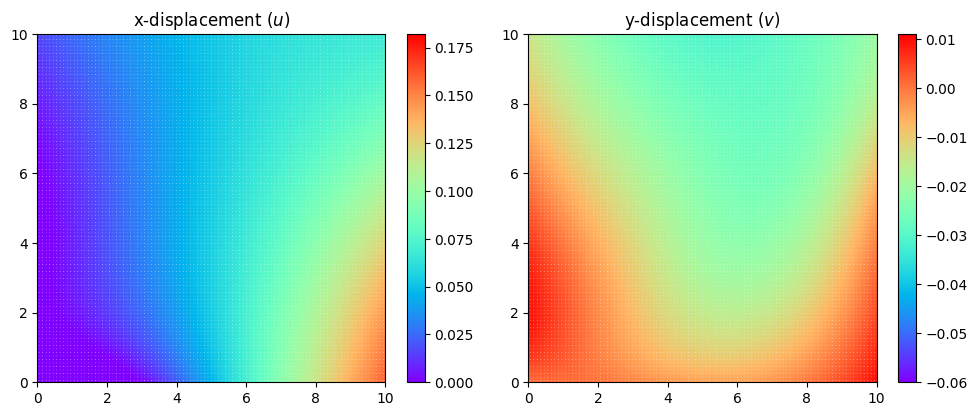

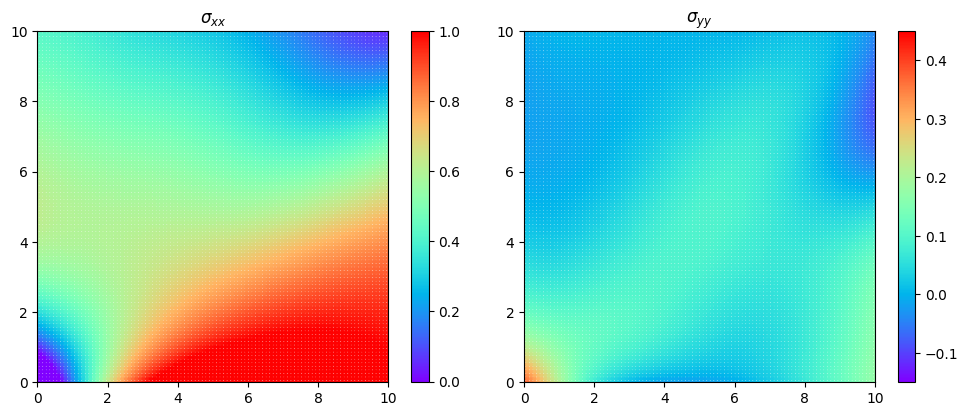

In [ ]:
titles = ['x-displacement ($u$)', 'y-displacement ($v$)', '$\sigma_{xx}$', '$\sigma_{yy}$']

color_legend = [[0, 0.182], [-0.06, 0.011], [-0.0022, 1.0], [-0.15, 0.45]]

plot_results(result, color_legend[:2], titles[:2], w)
plot_results(sigma, color_legend[2:], titles[2:], w)

<br>

__Comparison with FEM data along the line $y=x$__

- [lab2_Plate Data](https://drive.google.com/file/d/1J80didBUGt0Cts6HTk1KNmGqMNQWR4Uf/view?usp=sharing)

<br>

In [ ]:
Plate_data = np.load('/content/drive/MyDrive/25_소성_tutorial/lab2_Plate_data.npy')
loc = Plate_data[:, 0:2]
u = Plate_data[:, 2:3]
v = Plate_data[:, 3:4]
stress = Plate_data[:, 4:6]

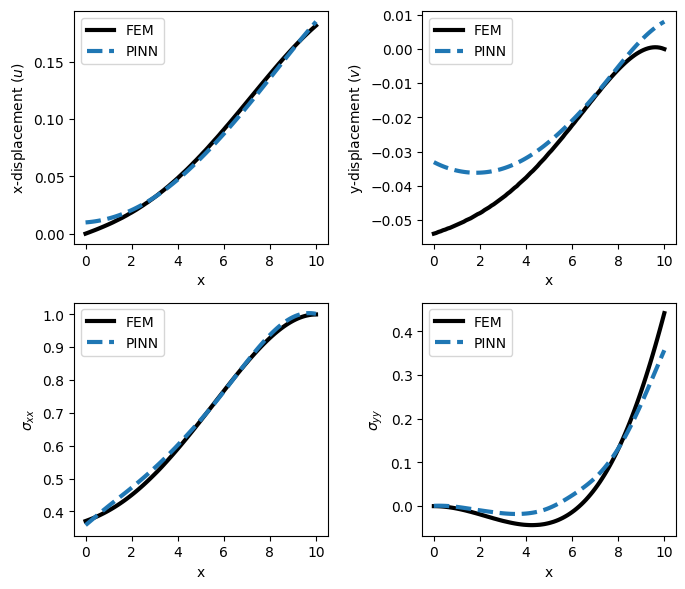

In [ ]:
def RESULT(test_model, diag):
    diag = require_grad(diag)
    pde_u, pde_v = test_model(diag)
    pde_disp = np.hstack([pde_u.cpu().detach().numpy(), pde_v.cpu().detach().numpy()])
    sig_x, sig_y = check_stress(test_model, diag)
    pde_sig = np.hstack([sig_x.cpu().detach().numpy(), sig_y.cpu().detach().numpy()])
    return pde_disp, pde_sig

diag_ = [i for i in range(u.shape[0]) if loc[i, 0] + loc[i, 1] == 10]
diag_x = np.linspace(0, 10, 101).reshape(-1, 1)
diag_y = -diag_x + 10
diag = np.concatenate((diag_x, diag_y), 1)

model_Adam = torch.load('/content/drive/MyDrive/25_소성_tutorial/lab2_adam_model.pt', weights_only=False)

results = {
    "FEM": [u[diag_], v[diag_], stress[diag_, 0], stress[diag_, 1]],
    "PINN": RESULT(model_Adam, diag),
}

for key in ["PINN"]:
    disp, sig = results[key]
    results[key] = [disp[:, 0], disp[:, 1], sig[:, 0], sig[:, 1]]

titles = ['x-displacement ($u$)', 'y-displacement ($v$)', '$\sigma_{xx}$', '$\sigma_{yy}$']
line_styles = {'FEM': 'k', 'PINN': '--'}

plt.figure(figsize = (7, 6))

for idx, title in enumerate(titles):
    plt.subplot(2, 2, idx + 1)
    for label, result in results.items():
        plt.plot(diag[:, 0], result[idx], line_styles[label], linewidth = 3, label = label)

    plt.xlabel('x')
    plt.ylabel(title)
    plt.legend()

plt.tight_layout()
plt.show()


## 2.3. PINN + data

### 2.3.1 Load and Sample Data

- [lab2_Plate Data](https://www.dropbox.com/scl/fi/e7my80q7mii3aliyhwamk/lab2_Plate_data.npy?rlkey=h5r6d0qsxnmpbdhms2tumq3ue&st=02os4rm1&dl=0)

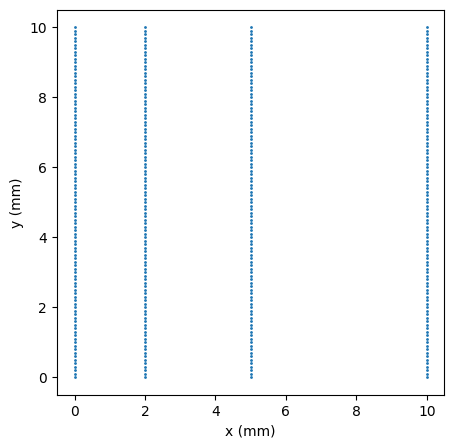

In [ ]:
Plate_data = np.load('/content/drive/MyDrive/25_소성_tutorial/lab2_Plate_data.npy')
loc = Plate_data[:, 0:2]
u = Plate_data[:, 2:3]
v = Plate_data[:, 3:4]
stress = Plate_data[:, 4:6]

x_values = [0, 2, 5, 10]
tr_sample = np.where(np.isin(loc[:, 0], x_values))[0]
x_sample = loc[tr_sample, :]
u_sample = u[tr_sample, :]
v_sample = v[tr_sample, :]
stress_sample = stress[tr_sample, :]
# big_data = [x_sample, u_sample, v_sample]
data = np.concatenate([x_sample, u_sample, v_sample, stress_sample], axis=1)

plt.figure(figsize = (5, 5))
plt.scatter(x_sample[:, 0], x_sample[:, 1], s = 1)
plt.xlim([-0.5, 10.5])
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

### 2.3.2. Define Data-Driven Loss term

In [ ]:
def DATA(model, loc):
    u, v = model(loc)
    u_x, _ = derivative(u, loc)
    _, v_y = derivative(v, loc)
    sigma_xx = E / (1 - nu ** 2) * (u_x + nu * v_y)
    sigma_yy = E / (1 - nu ** 2) * (v_y + nu * u_x)
    sigma = torch.cat((sigma_xx, sigma_yy), dim=1)
    return u, v, sigma

In [ ]:
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 10000
best_loss = np.inf

loc = require_grad(data[:, 0:2])
gt_u = require_grad(data[:, 2:3])
gt_v = require_grad(data[:, 3:4])
gt_sigma = require_grad(data[:, 4:6])

for epoch in range(epochs):

    # PDE
    force_eq_x, force_eq_y = PDE(model, XY_domain)
    loss_PDE_x = loss_fn(force_eq_x, torch.zeros_like(force_eq_x))
    loss_PDE_y = loss_fn(force_eq_y, torch.zeros_like(force_eq_y))
    loss_PDE = loss_PDE_x + loss_PDE_y

    # BC
    bottom_v = BC_bottom(model, XY_bottom)
    left_u = BC_left(model, XY_left)
    top_sigyy, top_sigyx = BC_top(model, XY_top)
    right_sigxx, right_sigex, right_sigxy = BC_right(model, XY_right)

    loss_BC_bottom = loss_fn(bottom_v, torch.zeros_like(bottom_v))
    loss_BC_left = loss_fn(left_u, torch.zeros_like(left_u))

    loss_BC_top_1 = loss_fn(top_sigyy, torch.zeros_like(top_sigyy))
    loss_BC_top_2 = loss_fn(top_sigyx, torch.zeros_like(top_sigyx))
    loss_BC_top = loss_BC_top_1 + loss_BC_top_2

    loss_BC_right_1 = loss_fn(right_sigxx, right_sigex)
    loss_BC_right_2 = loss_fn(right_sigxy, torch.zeros_like(right_sigxy))
    loss_BC_right = loss_BC_right_1 + loss_BC_right_2
    loss_BC = loss_BC_bottom + loss_BC_left + loss_BC_top + loss_BC_right

    # DATA
    data_u, data_v, data_sigma = DATA(model, loc)
    loss_Data_u = loss_fn(data_u, gt_u)
    loss_Data_v = loss_fn(data_v, gt_v)
    loss_Data_sigma = loss_fn(data_sigma, gt_sigma)
    loss_Data = loss_Data_u + loss_Data_v + loss_Data_sigma

    # Total
    loss = loss_PDE + loss_BC + loss_Data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # if loss.item() < best_loss:
    #     best_loss = loss.item()
    #     torch.save(model, 'lab2_data_model.pt')

    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')

print('Training Finish')

Epoch: 0, Loss: 17.978927612304688
Epoch: 1000, Loss: 0.0031307986937463284
Epoch: 2000, Loss: 0.000998490140773356
Epoch: 3000, Loss: 0.0006014038226567209
Epoch: 4000, Loss: 0.0003532151458784938
Epoch: 5000, Loss: 0.00022965873358771205
Epoch: 6000, Loss: 0.002326028188690543
Epoch: 7000, Loss: 0.00011969370825681835
Epoch: 8000, Loss: 0.00016370649973396212
Epoch: 9000, Loss: 0.00011727548553608358
Training Finish


#### Load the model parameters
- [lab2_adam_w_data_model.pt](https://www.dropbox.com/scl/fi/ygmh61tqdngpk22nl3yfl/lab2_adam_w_data_model.pt?rlkey=3j2f7gr48n27zmeq5guz5j5op&st=3fjz4phm&dl=0)

In [ ]:
model = torch.load('/content/drive/MyDrive/25_소성_tutorial/lab2_data_model.pt', weights_only=False)

### 2.3.3. Plot Results

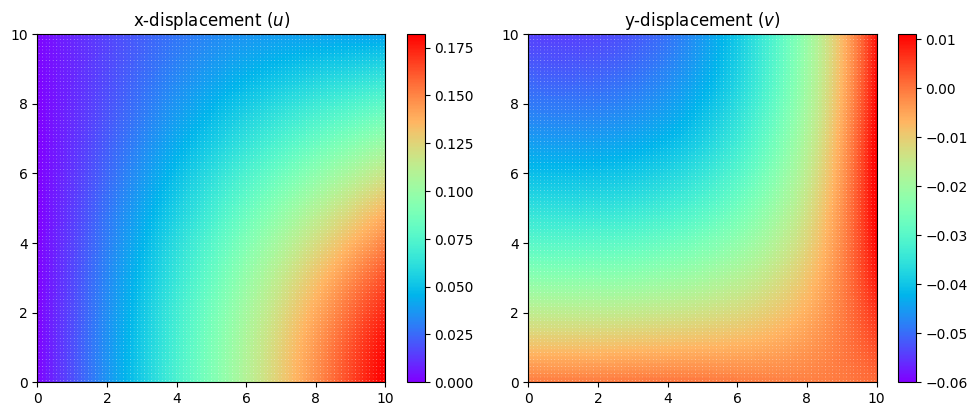

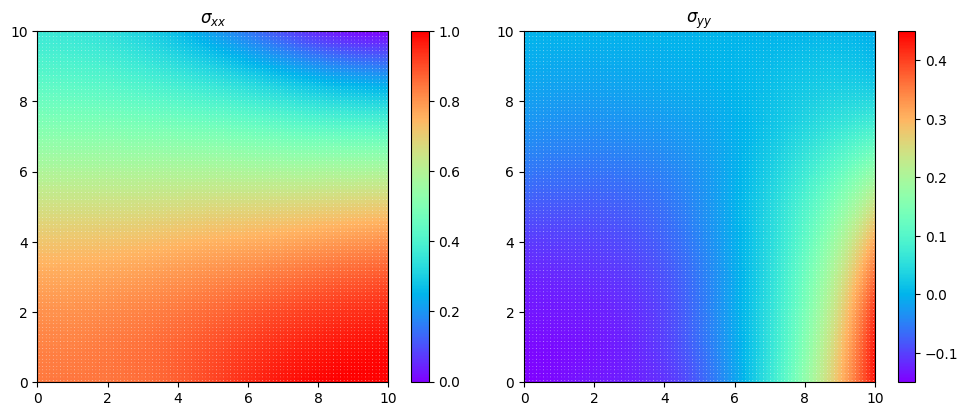

In [ ]:
with torch.no_grad():
    model.eval()
    result = model(test_tensor)

sigma_xx, sigma_yy = check_stress(model, test_tensor)
sigma = [sigma_xx, sigma_yy]

plot_results(result, color_legend[:2], titles[:2], w)
plot_results(sigma, color_legend[2:], titles[2:], w)

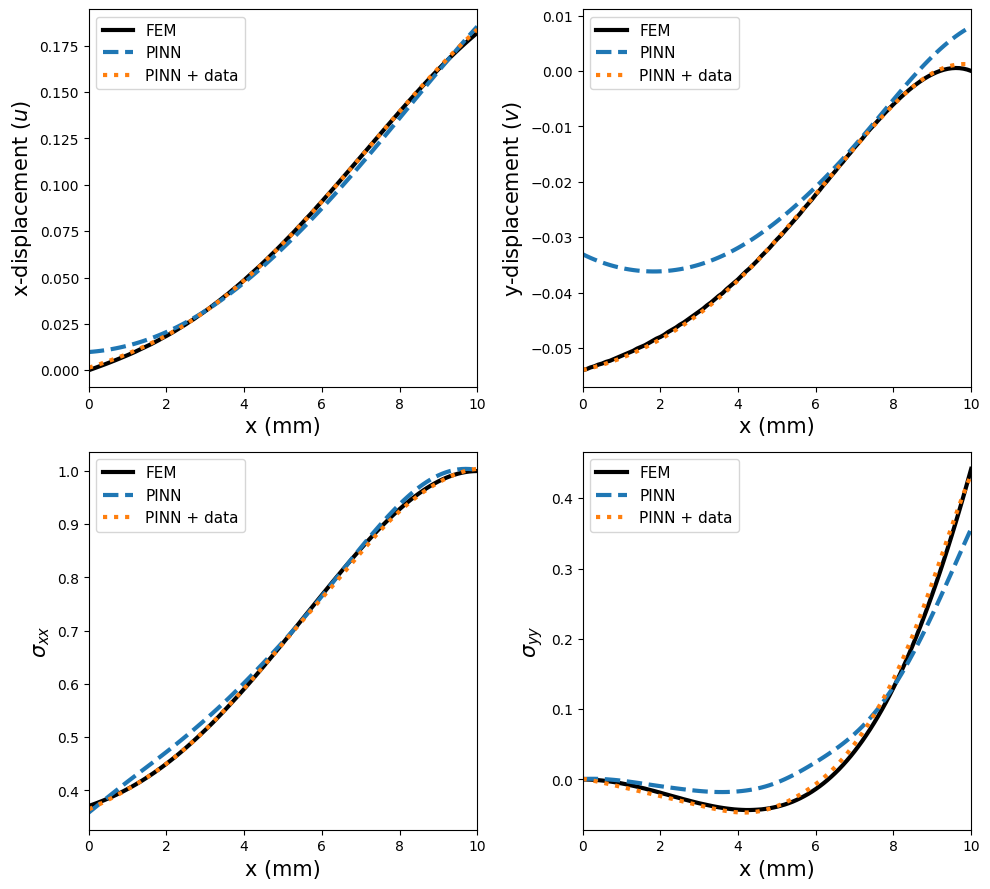

In [ ]:
Plate_data = np.load('/content/drive/MyDrive/25_소성_tutorial/lab2_Plate_data.npy')
loc = Plate_data[:, 0:2]
u = Plate_data[:, 2:3]
v = Plate_data[:, 3:4]
stress = Plate_data[:, 4:6]

def RESULT(test_model, diag):
    diag = require_grad(diag)
    pde_u, pde_v = test_model(diag)
    pde_disp = np.hstack([pde_u.cpu().detach().numpy(), pde_v.cpu().detach().numpy()])
    sig_x, sig_y = check_stress(test_model, diag)
    pde_sig = np.hstack([sig_x.cpu().detach().numpy(), sig_y.cpu().detach().numpy()])
    return pde_disp, pde_sig

diag_ = [i for i in range(u.shape[0]) if loc[i, 0] + loc[i, 1] == 10]
diag_x = np.linspace(0, 10, 101).reshape(-1, 1)
diag_y = -diag_x + 10
diag = np.concatenate((diag_x, diag_y), 1)

model_Adam = torch.load('/content/drive/MyDrive/25_소성_tutorial/lab2_adam_model.pt', weights_only=False)
model_Data = torch.load('/content/drive/MyDrive/25_소성_tutorial/lab2_data_model.pt', weights_only=False)

results = {
    "FEM": [u[diag_], v[diag_], stress[diag_, 0], stress[diag_, 1]],
    "PINN": RESULT(model_Adam, diag),
    "PINN + data": RESULT(model_Data, diag)
}

for key in ["PINN", "PINN + data"]:
    disp, sig = results[key]
    results[key] = [disp[:, 0], disp[:, 1], sig[:, 0], sig[:, 1]]

titles = ['x-displacement ($u$)', 'y-displacement ($v$)', '$\sigma_{xx}$', '$\sigma_{yy}$']
line_styles = {'FEM': 'k', 'PINN': '--', 'PINN + data': ':'}

plt.figure(figsize=(10, 9))

for idx, title in enumerate(titles):
    plt.subplot(2, 2, idx + 1)
    for label, result in results.items():
        plt.plot(diag[:, 0], result[idx], line_styles[label], linewidth=3, label=label)
    plt.xlabel('x (mm)', fontsize=15)
    plt.ylabel(title, fontsize=15)
    plt.xlim((0, 10))
    plt.legend(fontsize=11)

plt.tight_layout()
plt.show()




---



<br><br><br>
# Lab 3. Plastic Deformation of Circular Cylinder

## 3.1. Problem Setup

- Find plastic deformation of circular cylinder


- Measure the change in circumference length while filling the cylinder with pressure
   - The pressure increases linearly with time $(p=p_0 \lambda)$
   - Governing equation: J2-flow theory for plastic deformation

<br>
    
$$
\frac{\partial \epsilon_{22}^{p}}{\partial \lambda}-\frac{3}{4} \left( {1 \over nC({2 \over \sqrt{3}}\epsilon^{p}_{22})^{n-1}}- {1 \over E}\right){p_{o}r \over t} = 0   
$$
   
   <br>

- Initial condition for plastic deformation

   <br>

$$
\epsilon_{22}^{p} \left({2t \over \sqrt{3}p_{0}r}\sigma_y\right) = 0,    \quad \text{where} \  \sigma_y = \text{yield stress}
$$
   <br>
  

  
<br><br>
<center>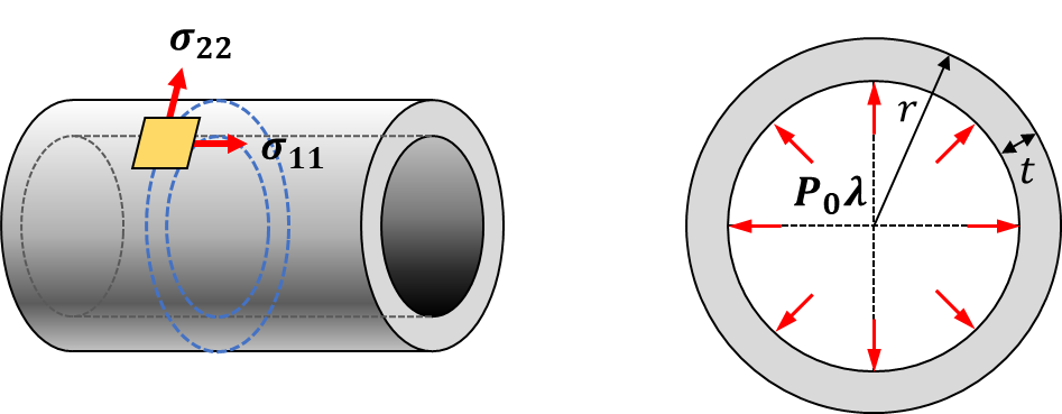</center>
<br><br>

<br>

__Import Library & Define Properties__

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
from torch.nn import Linear, Tanh

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# properties
r = 0.25
tt = 0.002
l0 = 2*np.pi*r
p0 = 10
alpha = 0.1
sig_y = 250
lambda_0 = 2*tt*sig_y/(np.sqrt(3)*p0*r)
E = 200000
n = 0.26
C = 500

<br>

__Define Collocation Points__



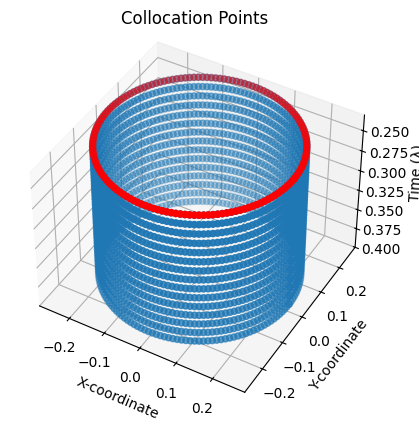

In [ ]:
Nr = 150
Nt = 150

cylinder_center = [0, 0]

theta = torch.linspace(0, 2 * np.pi, Nr)
t     = torch.linspace(lambda_0, 0.4, Nt)

x = (cylinder_center[0] + r * torch.cos(theta)).reshape(-1, 1)
y = (cylinder_center[1] + r * torch.sin(theta)).reshape(-1, 1)
xy = torch.cat([x, y], dim=1)

X, T = torch.meshgrid(xy[:, 0], t)
Y, T = torch.meshgrid(xy[:, 1], t)
Y_domain = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1), T.reshape(-1, 1)], dim=1)

Y_ic = Y_domain[Y_domain[:, 2] == lambda_0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Y_domain[::10, 0], Y_domain[::10, 1], Y_domain[::10, 2])
ax.scatter(Y_ic[:, 0], Y_ic[:, 1], Y_ic[:, 2], c='red')

# 축 레이블 설정
ax.set_title('Collocation Points')
# ax.set_title(r'Strain $({}_{}^{})$'.format(chr(0x03B5), {22}, 'p'))
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_zlabel('Time ({})'.format(chr(0x03BB)))
ax.set_zlim(0.4, lambda_0)
ax.view_init(elev=42)

plt.show()

## 3.2. Data-driven Approach with Small Data

<br>

__Load and Sample Data__

- [lab0_gt_data](https://drive.google.com/file/d/17pDYOVMs42tJWk6DOp_68wI1yeUwsrxl/view?usp=sharing)

In [ ]:
gt_domain = np.load('/content/drive/MyDrive/25_소성_tutorial/lab0_gt_domain.npy')

Y_obs  = Y_domain[::15, :]
gt_obs = gt_domain[::15, :]

print('Y_obs shape : {}'.format(np.array(Y_obs).shape))
print('gt_obs shape: {}'.format(gt_obs.shape))

Y_obs shape : (1500, 3)
gt_obs shape: (1500, 1)


<br>

__Define Network and Hyper-parameters__



In [ ]:
class MODEL(nn.Module):
    def __init__(self):
        super(MODEL, self).__init__()
        self.net = nn.Sequential(
            Linear(3, 64),
            Tanh(),
            Linear(64, 64),
            Tanh(),
            Linear(64, 64),
            Tanh(),
            Linear(64, 64),
            Tanh(),
            Linear(64, 64),
            Tanh(),
            Linear(64, 1)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.float()
        strain = self.net(x)
        return strain

In [ ]:
model_SD = MODEL().to(device)

optimizer = torch.optim.Adam(model_SD.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='mean')

<br>

__Define Functions__

In [ ]:
def requires_grad(x):
    return torch.tensor(x, dtype = torch.float32, requires_grad = True).to(device)

<br>

__Train__


In [ ]:
Y_obs  = requires_grad(Y_obs)
gt_obs = requires_grad(gt_obs)

for epoch in range(5001):

    strain_obs = model_SD(Y_obs)

    loss_data = loss_fn(strain_obs, gt_obs)

    loss = 100 * loss_data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print('Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))

/tmp/ipython-input-34-2023326064.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype = torch.float32, requires_grad = True).to(device)


Epoch: 0 Loss: 0.233445
Epoch: 1000 Loss: 0.003974
Epoch: 2000 Loss: 0.003968
Epoch: 3000 Loss: 0.003960
Epoch: 4000 Loss: 0.003953
Epoch: 5000 Loss: 0.003947


<br>

__Results__



Load the model parameters

- [lab0_data_model.pt](https://drive.google.com/file/d/1vBzKGNcRacjXCU1W_ptj79TKOCuFT5ER/view?usp=sharing)

<br>

/tmp/ipython-input-34-2023326064.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype = torch.float32, requires_grad = True).to(device)


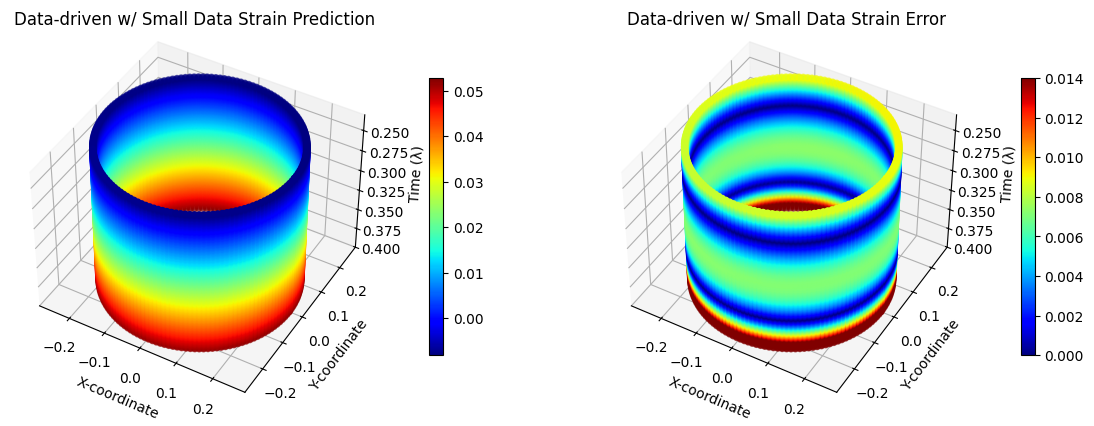

In [ ]:
with torch.no_grad():
    test_model = torch.load('/content/drive/MyDrive/25_소성_tutorial/pd_SD.pt', weights_only=False)
    pred = test_model(requires_grad(Y_domain))

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100, subplot_kw={'projection': '3d'})
    ax1 = axs[0]

    sc1 = ax1.scatter(Y_domain[:, 0].detach().cpu().numpy(), Y_domain[:, 1].detach().cpu().numpy(), Y_domain[:, 2].detach().cpu().numpy(), c=pred.detach().cpu().numpy(), cmap='jet', zorder=0)

    ax1.set_title(r'Data-driven w/ Small Data Strain Prediction')
    ax1.set_xlabel('X-coordinate')
    ax1.set_ylabel('Y-coordinate')
    ax1.set_zlabel('Time ({})'.format(chr(0x03BB)))
    ax1.set_zlim(0.4, lambda_0)
    ax1.view_init(elev=42)
    fig.colorbar(
        sc1,
        ax=ax1,
        shrink=0.6,   # 컬러바 길이 비율
        pad=0.1,      # 축과 컬러바 간 간격
    )

    ax2 = axs[1]
    sc2= ax2.scatter(Y_domain[:, 0].detach().cpu().numpy(), Y_domain[:, 1].detach().cpu().numpy(), Y_domain[:, 2].detach().cpu().numpy(), c=np.abs(gt_domain.detach().cpu().numpy() - pred.detach().cpu().numpy()), vmin=0, vmax=0.07*0.2, cmap='jet', zorder=0)

    ax2.set_title(r'Data-driven w/ Small Data Strain Error')
    ax2.set_xlabel('X-coordinate')
    ax2.set_ylabel('Y-coordinate')
    ax2.set_zlabel('Time ({})'.format(chr(0x03BB)))
    ax2.set_zlim(0.4, lambda_0)
    ax2.view_init(elev=42)
    fig.colorbar(
        sc2,
        ax=ax2,
        shrink=0.6,   # 컬러바 길이 비율
        pad=0.1,      # 축과 컬러바 간 간격
    )
    plt.show()

## 3.3. PINN with Small Data

<br>

__Define Network and Hyper-parameters__



In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            Linear(3, 64),
            Tanh(),
            Linear(64, 64),
            Tanh(),
            Linear(64, 64),
            Tanh(),
            Linear(64, 64),
            Tanh(),
            Linear(64, 64),
            Tanh(),
            Linear(64, 1)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.float()
        strain = self.net(x)
        return strain

In [ ]:
model_PSD = PINN().to(device)

optimizer = torch.optim.Adam(model_PSD.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='mean')

<br>

__Define Functions to Compute Physics Loss__



In [ ]:
def derivative(y, t):
    df = torch.autograd.grad(y, t, grad_outputs = torch.ones_like(y).to(device), create_graph = True)[0]
    df_x = df[:, 0:1]
    df_y = df[:, 1:2]
    df_t = df[:, 2:3]
    return df_x, df_y, df_t

def requires_grad(x):
    return torch.tensor(x, dtype = torch.float32, requires_grad = True).to(device)

<br>

__Define PDE with Initial Conditions__


In [ ]:
def PDE(model, Y_domain):
    s = model(Y_domain)

    _, _, ds_t = derivative(s, Y_domain)

    idx = np.where(s.detach().cpu().numpy() >= 0)[0]

    nonlinear_res = ds_t[idx] - (3/4)*(1/(n*C*((2/1.732050808)*s[idx])**(n-1))-1/E)*((p0*r)/tt)

    return nonlinear_res.float()

In [ ]:
def IC(model, Y_ic):
    s_ic = model(Y_ic) - 0.001 * torch.ones_like(Y_ic).to(device)
    return s_ic

<br>

__Train__


In [ ]:
Y_domain  = requires_grad(Y_domain)
Y_obs     = requires_grad(Y_obs)
Y_ic      = requires_grad(Y_ic)
gt_domain = requires_grad(gt_domain)
gt_obs    = requires_grad(gt_obs)

for epoch in range(5001):

    strain_obs = model_PSD(Y_obs)

    loss_data = loss_fn(strain_obs, gt_obs)

    J2_flow = PDE(model_PSD, Y_domain)
    loss_PDE = loss_fn(J2_flow, torch.zeros_like(J2_flow).to(device))

    ic_s = IC(model_PSD, Y_ic)
    loss_IC = loss_fn(ic_s, torch.zeros_like(ic_s).to(device))

    loss = 1 * (loss_PDE + loss_IC) + 100 * loss_data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print('Epoch: {} Loss: {:.6f} PDELoss: {:.6f} ICLoss: {:.6f} DATALoss: {:.6f}'.format(epoch,
        loss.item(), loss_PDE.item(), loss_IC.item(), loss_data.item()))
    epoch += 1

/tmp/ipython-input-40-4159140895.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype = torch.float32, requires_grad = True).to(device)


Epoch: 0 Loss: 0.616603 PDELoss: 0.385143 ICLoss: 0.001346 DATALoss: 0.002301
Epoch: 1000 Loss: 0.055136 PDELoss: 0.026043 ICLoss: 0.000066 DATALoss: 0.000290
Epoch: 2000 Loss: 0.016167 PDELoss: 0.012938 ICLoss: 0.000000 DATALoss: 0.000032
Epoch: 3000 Loss: 0.008237 PDELoss: 0.007779 ICLoss: 0.000000 DATALoss: 0.000005
Epoch: 4000 Loss: 0.000927 PDELoss: 0.000895 ICLoss: 0.000000 DATALoss: 0.000000
Epoch: 5000 Loss: 0.000431 PDELoss: 0.000420 ICLoss: 0.000000 DATALoss: 0.000000


<br>

__Results__



Load the model parameters

- [lab0_PINN_model.pt](https://drive.google.com/file/d/1yTg9bOfn-qnkFCm3yRcUFtj_7ssAVFWs/view?usp=sharing)

<br>

/tmp/ipython-input-40-4159140895.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype = torch.float32, requires_grad = True).to(device)


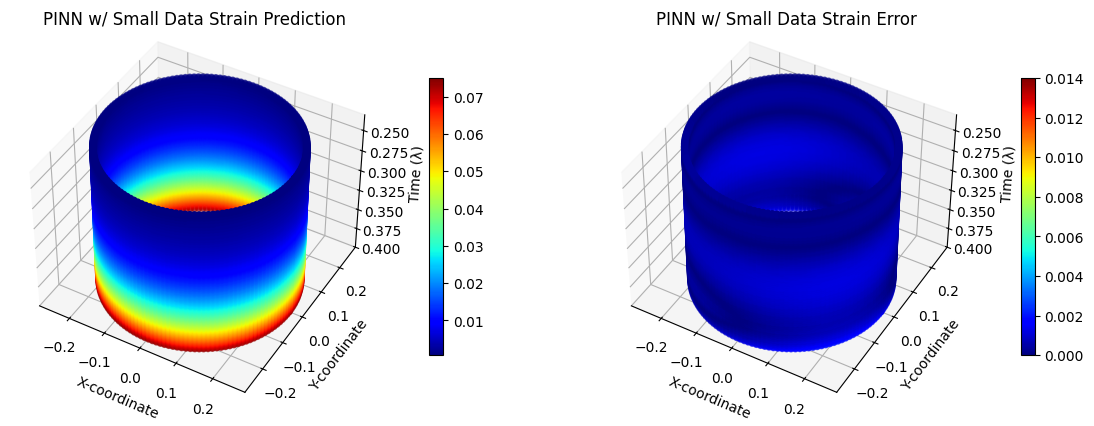

In [ ]:
with torch.no_grad():
    test_model = torch.load('/content/drive/MyDrive/25_소성_tutorial/pd_pinn_SD.pt', weights_only=False)
    pred = test_model(requires_grad(Y_domain))

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100, subplot_kw={'projection': '3d'})
    ax1 = axs[0]

    sc1 = ax1.scatter(Y_domain[:, 0].detach().cpu().numpy(), Y_domain[:, 1].detach().cpu().numpy(), Y_domain[:, 2].detach().cpu().numpy(), c=pred.detach().cpu().numpy(), cmap='jet', zorder=0)

    ax1.set_title(r'PINN w/ Small Data Strain Prediction')
    ax1.set_xlabel('X-coordinate')
    ax1.set_ylabel('Y-coordinate')
    ax1.set_zlabel('Time ({})'.format(chr(0x03BB)))
    ax1.set_zlim(0.4, lambda_0)
    ax1.view_init(elev=42)
    fig.colorbar(
        sc1,
        ax=ax1,
        shrink=0.6,   # 컬러바 길이 비율
        pad=0.1,      # 축과 컬러바 간 간격
    )

    ax2 = axs[1]
    sc2 = ax2.scatter(Y_domain[:, 0].detach().cpu().numpy(), Y_domain[:, 1].detach().cpu().numpy(), Y_domain[:, 2].detach().cpu().numpy(), c=np.abs(gt_domain.detach().cpu().numpy() - pred.detach().cpu().numpy()), vmin=0, vmax=0.07*0.2, cmap='jet', zorder=0)

    ax2.set_title(r'PINN w/ Small Data Strain Error')
    ax2.set_xlabel('X-coordinate')
    ax2.set_ylabel('Y-coordinate')
    ax2.set_zlabel('Time ({})'.format(chr(0x03BB)))
    ax2.set_zlim(0.4, lambda_0)
    ax2.view_init(elev=42)
    fig.colorbar(
        sc2,
        ax=ax2,
        shrink=0.6,   # 컬러바 길이 비율
        pad=0.1,      # 축과 컬러바 간 간격
    )
    plt.show()

<br>

__Comparison with Data-Driven and PINN__



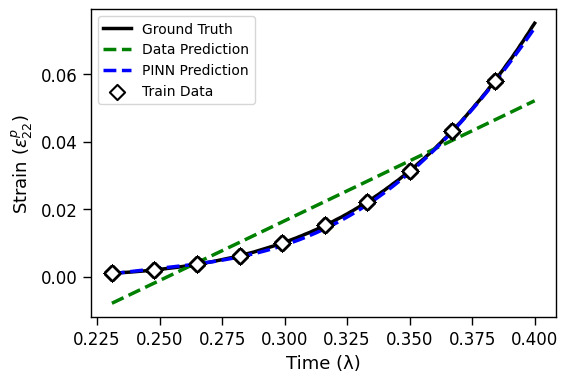

In [ ]:
with torch.no_grad():
    test_model_pinn = torch.load('/content/drive/MyDrive/25_소성_tutorial/pd_pinn_SD.pt', weights_only=False)
    test_model_data = torch.load('/content/drive/MyDrive/25_소성_tutorial/pd_SD.pt', weights_only=False)

    pred_pinn = test_model_pinn(Y_domain)
    pred_data = test_model_data(Y_domain)

    fig = plt.figure(figsize=(6, 4), dpi=100)
    ax = fig.add_subplot()

    thickness = 1

    for axis in ['top', 'bottom', 'right', 'left']:
        ax.spines[axis].set_linewidth(thickness)

    ax.tick_params(width=thickness, length=6, labelsize=12)

    plt.plot(Y_domain[:150, 2].detach().cpu().numpy(), gt_domain[:150, 0].detach().cpu().numpy(), linewidth=2.5, color='k', label='Ground Truth', zorder=0)
    plt.plot(Y_domain[:150, 2].detach().cpu().numpy(), pred_data[:150, 0].detach().cpu().numpy(), linestyle='--', linewidth=2.5, color='g', label='Data Prediction', zorder=1)
    plt.plot(Y_domain[:150, 2].detach().cpu().numpy(), pred_pinn[:150, 0].detach().cpu().numpy(), linestyle='--', linewidth=2.5, color='b', label='PINN Prediction', zorder=1)
    plt.scatter(Y_obs[:, 2].detach().cpu().numpy(), gt_obs.detach().cpu().numpy(), s=60, marker='D', linewidths=1.5, edgecolors='k', color='white', label='Train Data', zorder=2)
    plt.xlabel('Time ({})'.format(chr(0x03BB)), fontsize=13)
    plt.ylabel(r'Strain $({}_{}^{})$'.format(chr(0x03B5), {22}, 'p'), fontsize=13)
    plt.legend()
    plt.show()



---



<br><br><br>
# Lab 4. Inverse Problem: Parameter Estimation

## 4.1 Problem Setup

- Now, we will solve an inverse problem using PINN

<br>
</center>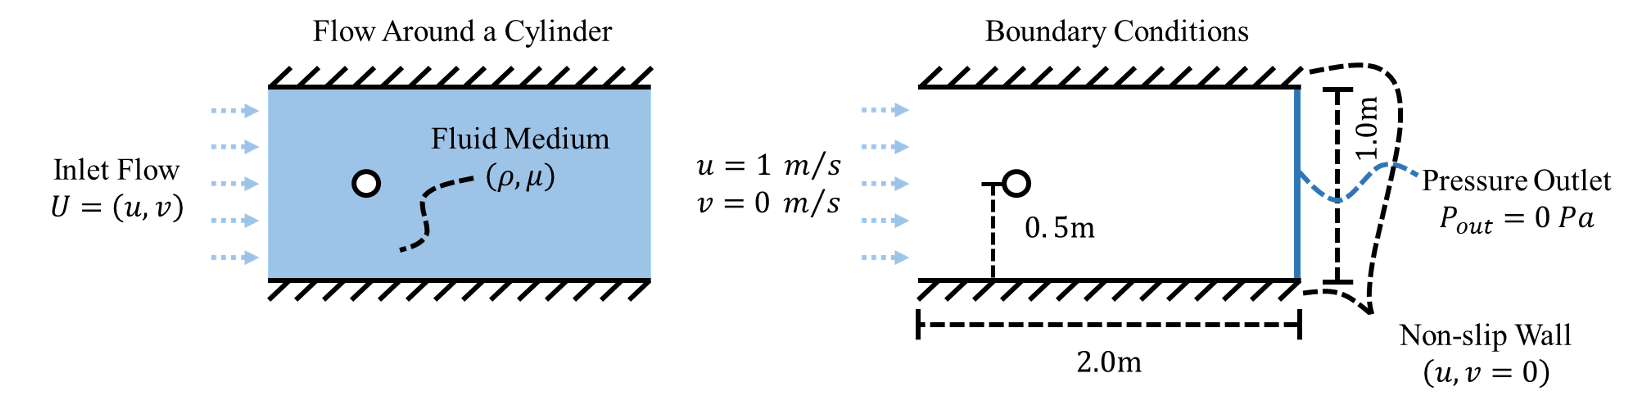

- Problem properties

$$\rho = ? \quad \nu = ?$$
<br>

- Partial differential equations & boundary conditions

<br>
$$
\rho\left(u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} + \frac{1}{\rho}\frac{\partial p}{\partial x}   \right) - \mu\left( \frac{\partial^2u}{\partial^2 x} + \frac{\partial^2u}{\partial^2 y}\right) = 0$$

<br>
$$
\rho\left(u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} + \frac{1}{\rho}\frac{\partial p}{\partial y}   \right) - \mu\left( \frac{\partial^2v}{\partial^2 x} + \frac{\partial^2v}{\partial^2 y}\right) = 0$$

<br>

- Inlet boundary condition ($x=-0.5$):

<br>
$$u|_{x = -0.5} = 1$$

- Outlet boundary condition ($x=1.5$):

<br>
$$v|_{x = 1.5} = 0$$
$$p|_{x = 1.5} = 0$$

- Non-slip boundary condition ($y=\pm 0.5$):

<br>
$$u|_{y = \pm 0.5} = 0$$
$$v|_{y = \pm 0.5} = 0$$


- Make a neural network and loss functions like below :

<center>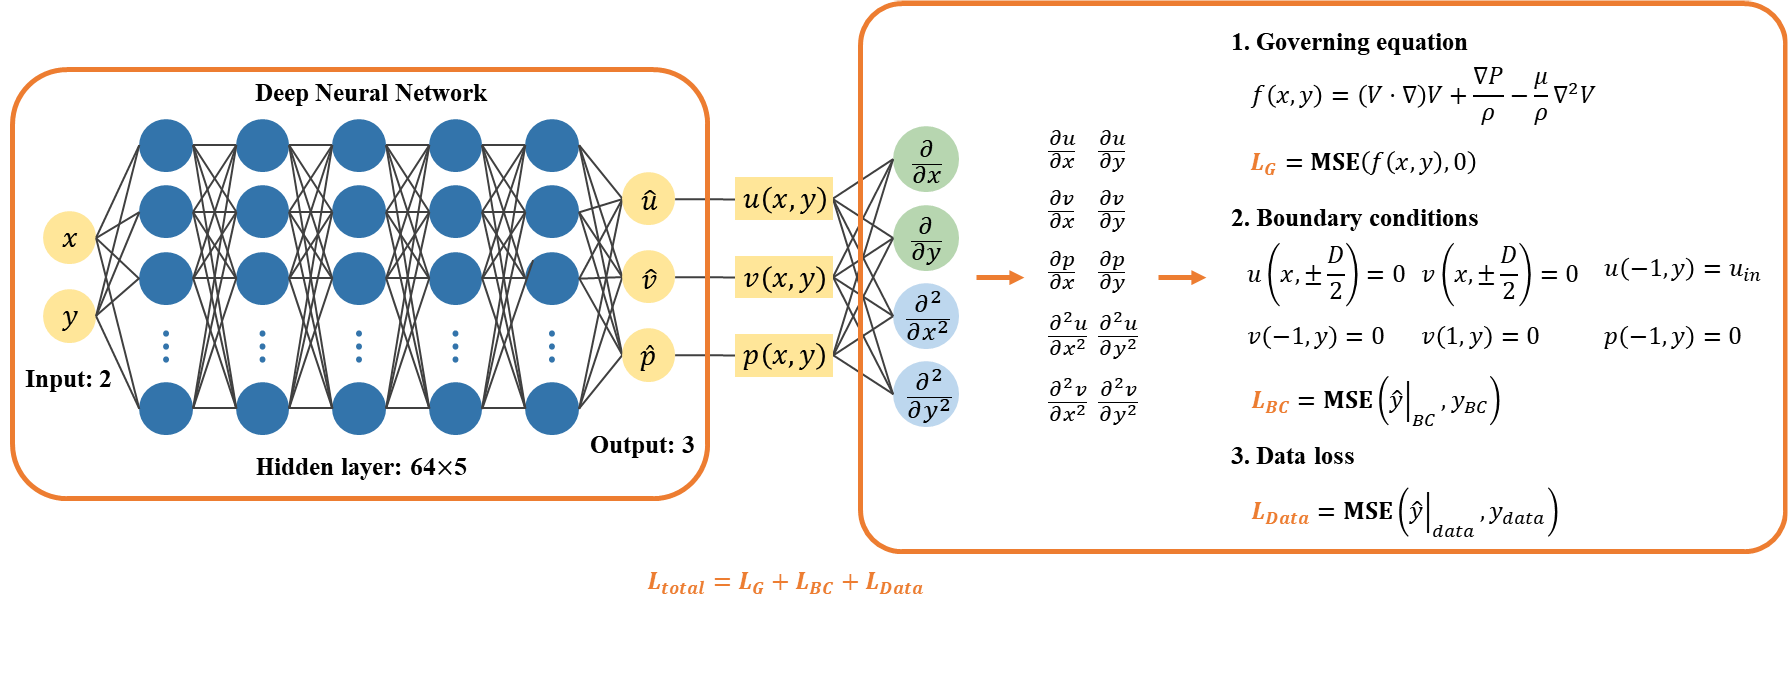

## 4.2 Solve the Inverse Problem

### 4.2.1 Import Library

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# true values
C1true = 1.0
C2true = 0.01

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### 4.2.2 Load the Data

- [lab3_XY_domain](https://www.dropbox.com/scl/fi/7ws4dmqu6gmktoy3zjntt/lab3_XY_domain.npy?rlkey=fvyrvlpw1a0tb3thl94obh7if&st=qtxj7loo&dl=0)
- [lab3_gt_domain](https://www.dropbox.com/scl/fi/3xcyjib52nf6gtrvaytf9/lab3_gt_domain.npy?rlkey=jch4juwnmfdbjwu9d90uwz9zk&st=neuryl1e&dl=0)

In [ ]:
xy_domain= np.load('/content/drive/MyDrive/25_소성_tutorial/lab3_XY_domain.npy')
gt_domain = np.load('/content/drive/MyDrive/25_소성_tutorial/lab3_gt_domain.npy')
print(xy_domain.shape)
print(gt_domain.shape)

(19692, 2)
(19692, 3)


### 4.2.3 Define Collocation Points

In [ ]:
'Boundary Conditions'
bc_top_x = np.linspace(-0.5, 1.5, 200).reshape(-1, 1)
bc_top_y = 0.5 * np.ones_like(bc_top_x).reshape(-1, 1)

bc_bottom_x = np.linspace(-0.5, 1.5, 200).reshape(-1, 1)
bc_bottom_y = -0.5 * np.ones_like(bc_bottom_x).reshape(-1, 1)

bc_inlet_y = np.linspace(-0.5, 0.5, 100).reshape(-1, 1)
bc_inlet_x = -0.5 * np.ones_like(bc_inlet_y).reshape(-1, 1)

bc_outlet_y = np.linspace(-0.5, 0.5, 100).reshape(-1, 1)
bc_outlet_x = 1.5 * np.ones_like(bc_outlet_y).reshape(-1, 1)

xy_top = np.concatenate((bc_top_x, bc_top_y), 1)
xy_bottom = np.concatenate((bc_bottom_x, bc_bottom_y), 1)
xy_inlet = np.concatenate((bc_inlet_x, bc_inlet_y), 1)
xy_outlet = np.concatenate((bc_outlet_x, bc_outlet_y), 1)

radius = 0.05
theta = np.linspace(0, 2 * np.pi, 200)
bc_cylinder_x = (0 + radius * np.cos(theta)).reshape(-1, 1)
bc_cylinder_y = (0 + radius * np.sin(theta)).reshape(-1, 1)
xy_cylinder = np.concatenate((bc_cylinder_x, bc_cylinder_y), 1)

xy_wall = np.concatenate((xy_top, xy_bottom, xy_cylinder))


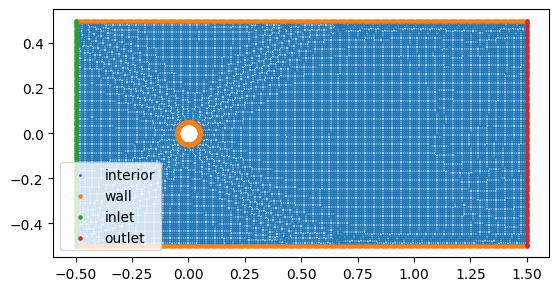

In [ ]:
plt.scatter(xy_domain[:, 0], xy_domain[:, 1], s = 1, label='interior')
plt.scatter(xy_wall[:, 0], xy_wall[:, 1], s = 5, label='wall')
plt.scatter(xy_inlet[:, 0], xy_inlet[:, 1], s = 5, label='inlet')
plt.scatter(xy_outlet[:, 0], xy_outlet[:, 1], s = 5, label='outlet')
plt.axis('scaled')
plt.legend()
plt.show()

### 4.2.4 Define Observation Points
- This CFD data is where the density $\rho$ is 1 and the viscosity $\mu$ is 0.01.

XY obs: (49, 2)
GT obs: (49, 3)


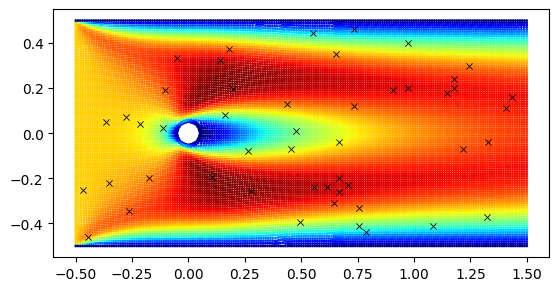

In [ ]:
idx_obs = np.random.choice(len(xy_domain), int(0.0025 * len(xy_domain)), replace=False)
xy_obs = xy_domain[idx_obs]
gt_obs = gt_domain[idx_obs]
print('XY obs: {}'.format(xy_obs.shape))
print('GT obs: {}'.format(gt_obs.shape))

plt.scatter(xy_domain[:, 0], xy_domain[:, 1], c = gt_domain[:, 0], s = 1, cmap = 'jet')
plt.scatter(xy_obs[:, 0], xy_obs[:, 1], marker = 'x', linewidths = 0.6, s = 20, c = 'k')
plt.axis('scaled')
plt.show()

### 4.2.5 Define PINN Network

In [ ]:
import torch.nn as nn
from torch.nn import Linear, Tanh

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
        Linear(2, 256),
        Tanh(),
        Linear(256, 256),
        Tanh(),
        Linear(256, 256),
        Tanh(),
        Linear(256, 256),
        Tanh(),
        Linear(256, 3),
        )

        self._initialize_weights()

    '''
    Xavier initializer (Glorot initialization):
    Initializes the weights to keep the variance consistent across layers,
    preventing issues like vanishing or exploding gradients. Weights are
    drawn from a distribution with variance 2/(fan_in + fan_out).
    Biases are set to zero.
    '''
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.float()
        output = self.net(x)
        u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        return u, v, p


### 4.2.6 Define Governing Eqaution and Boundary Conditions

In [ ]:
def derivative(y, t) :
    df = torch.autograd.grad(y, t, grad_outputs = torch.ones_like(y).to(device), create_graph = True)[0]
    df_x = df[:, 0:1]
    df_y = df[:, 1:2]
    return df_x, df_y

def PDE(model, XY_domain):
    u, v, p = model(XY_domain)

    du_x, du_y = derivative(u, XY_domain)
    dv_x, dv_y = derivative(v, XY_domain)
    dp_x, dp_y = derivative(p, XY_domain)

    du_xx, _ = derivative(du_x, XY_domain)
    _, du_yy = derivative(du_y, XY_domain)
    dv_xx, _ = derivative(dv_x, XY_domain)
    _, dv_yy = derivative(dv_y, XY_domain)

    pde_u = rho * (u * du_x + v * du_y) + dp_x - vis * (du_xx + du_yy)
    pde_v = rho * (u * dv_x + v * dv_y) + dp_y - vis * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y
    return pde_u, pde_v, pde_cont

def BC_wall(model, XY_wall):
    u_wall, v_wall, _ = model(XY_wall)
    return u_wall, v_wall

def BC_inlet(model, XY_inlet):
    u_inlet, v_inlet, _ = model(XY_inlet)
    u_inlet = u_inlet - torch.ones_like(u_inlet).to(device)

    return u_inlet, v_inlet

def BC_outlet(model, XY_outlet):
    _, v_outlet, p_outlet = model(XY_outlet)
    return v_outlet, p_outlet

### 4.2.7 Numpy to Tensor

In [ ]:
def require_grad(x):
    return torch.tensor(x, dtype = torch.float32, requires_grad = True).to(device)

XY_domain = require_grad(xy_domain)
XY_wall = require_grad(xy_wall)
XY_inlet = require_grad(xy_inlet)
XY_outlet = require_grad(xy_outlet)
XY_obs = require_grad(xy_obs)
gt_obs = require_grad(gt_obs)

'''
Initialize \rho and \mu as NumPy arrays with the value 1.
'''
rho = torch.ones(1).to(device).requires_grad_(True).float()
vis = torch.ones(1).to(device).requires_grad_(True).float()

model = PINN().to(device)
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr':1e-4},
                              {'params': rho, 'lr':1e-4},
                              {'params': vis, 'lr':1e-4}])
loss_fn = nn.MSELoss()

### 4.2.8 Train and Save the model

In [ ]:
epochs = 30001
best_loss = float('inf')
loss_list = []
rho_list, vis_list = [], []

for epoch in range(epochs):

    PDE_u, PDE_v, PDE_cont = PDE(model, XY_domain)
    loss_PDE_u = loss_fn(PDE_u, torch.zeros_like(PDE_u))
    loss_PDE_v = loss_fn(PDE_v, torch.zeros_like(PDE_v))
    loss_PDE_cont = loss_fn(PDE_cont, torch.zeros_like(PDE_cont))
    loss_pde = loss_PDE_u + loss_PDE_v + loss_PDE_cont

    u_wall, v_wall = BC_wall(model, XY_wall)
    u_inlet, v_inlet = BC_inlet(model, XY_inlet)
    v_outlet, p_outlet = BC_outlet(model, XY_outlet)

    loss_BC_wall_u = loss_fn(u_wall, torch.zeros_like(u_wall))
    loss_BC_wall_v = loss_fn(v_wall, torch.zeros_like(v_wall))
    loss_BC_inlet_u = loss_fn(u_inlet, torch.zeros_like(u_inlet))
    loss_BC_inlet_v = loss_fn(v_inlet, torch.zeros_like(v_inlet))
    loss_BC_outlet_v = loss_fn(v_outlet, torch.zeros_like(v_outlet))
    loss_BC_outlet_p = loss_fn(p_outlet, torch.zeros_like(p_outlet))
    loss_bc = loss_BC_wall_u + loss_BC_wall_v + loss_BC_inlet_u + loss_BC_inlet_v + loss_BC_outlet_v + loss_BC_outlet_p

    u_obs, v_obs, p_obs = model(XY_obs)
    loss_data_u = loss_fn(u_obs, gt_obs[:, 0:1])
    loss_data_v = loss_fn(v_obs, gt_obs[:, 1:2])
    loss_data_p = loss_fn(p_obs, gt_obs[:, 2:3])
    loss_data = loss_data_u + loss_data_v + loss_data_p

    loss = loss_pde + loss_bc + loss_data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    rho_list.append(rho.item())
    vis_list.append(vis.item())

    if loss.item() < best_loss:
        best_loss = loss.item()
#         torch.save(model, 'lab3.pt')

    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')


print('Training Finish')


Epoch: 0, Loss: 7.000944137573242
Epoch: 1000, Loss: 0.8413459658622742
Epoch: 2000, Loss: 0.6318556666374207
Epoch: 3000, Loss: 0.4714846611022949
Epoch: 4000, Loss: 0.3416963517665863
Epoch: 5000, Loss: 0.23687352240085602
Epoch: 6000, Loss: 0.15450696647167206
Epoch: 7000, Loss: 0.09283903986215591
Epoch: 8000, Loss: 0.050019945949316025
Epoch: 9000, Loss: 0.02363850548863411
Epoch: 10000, Loss: 0.010335470549762249
Epoch: 11000, Loss: 0.0056358822621405125
Epoch: 12000, Loss: 0.004766901023685932
Epoch: 13000, Loss: 0.00471544498577714
Epoch: 14000, Loss: 0.004714995622634888
Epoch: 15000, Loss: 0.004714995622634888
Epoch: 16000, Loss: 0.004714995622634888
Epoch: 17000, Loss: 0.0047150771133601665
Epoch: 18000, Loss: 0.004714996088296175
Epoch: 19000, Loss: 0.004714995622634888
Epoch: 20000, Loss: 0.0047149984166026115
Epoch: 21000, Loss: 0.0047152843326330185
Epoch: 22000, Loss: 0.004714995622634888
Epoch: 23000, Loss: 0.004714999347925186
Epoch: 24000, Loss: 0.004714995622634888


### 4.2.9 Result

In [ ]:
def PLOT(model, XY_domain, rho_list, vis_list):
    u, v, p = model(XY_domain)

    plt.figure(figsize = (9, 2))
    plt.subplot(1, 3, 1)
    plt.title('CFD')
    plt.scatter(XY_domain[:, 0].detach().cpu().numpy(), XY_domain[:, 1].detach().cpu().numpy(),
                c = gt_domain[:, 0], s = 0.1, cmap = 'jet')
    plt.axis('scaled')

    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.scatter(XY_domain[:, 0].detach().cpu().numpy(), XY_domain[:, 1].detach().cpu().numpy(),
                c = u.detach().cpu().numpy(), s = 0.1, cmap = 'jet')
    plt.axis('scaled')

    plt.subplot(1, 3, 3)
    plt.title('Error')
    plt.scatter(XY_domain[:, 0].detach().cpu().numpy(), XY_domain[:, 1].detach().cpu().numpy(),
                c = np.abs(u.detach().cpu().numpy() - gt_domain[:, 0:1]), s = 0.1, cmap = 'jet')
    plt.axis('scaled')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (6, 2))
    plt.subplot(1, 2, 1)
    plt.title('Rho Prediction')
    plt.plot(rho_list)

    plt.subplot(1, 2, 2)
    plt.title('Vis Prediction')
    plt.plot(vis_list)
    plt.tight_layout()
    plt.show()


#### Load the model parameters
- [lab3.pt](https://www.dropbox.com/scl/fi/ykxhh6987pnlbirhjc4hy/lab3.pt?rlkey=m8cy7tpmbfw5h119uk30hz7on&st=d6hrxw9d&dl=0)

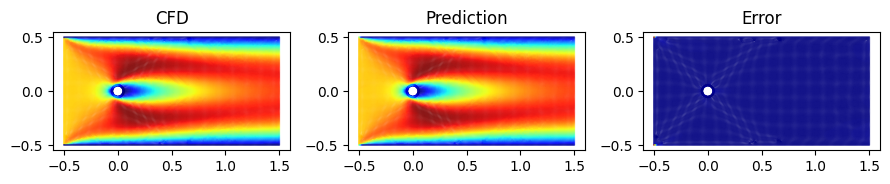

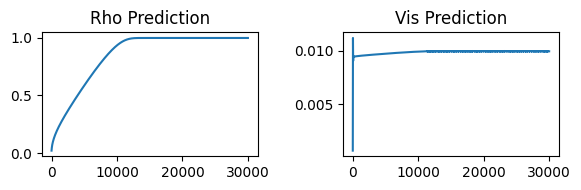

In [ ]:
with torch.no_grad():
    model = torch.load('/content/drive/MyDrive/25_소성_tutorial/lab3.pt', weights_only=False)
    PLOT(model, XY_domain, rho_list, vis_list)



---

